<div style="display: flex; background-color:rgb(214, 234, 248 );" >
<h1 style="text-align: center;margin: auto; padding: 40px; "> Implémentez un modèle de scoring
    Projet 7 Notebook Modélisation </h1>
    <p >  Zeynep Erdem 
      
</p>
      
  
</div>

<a name="top"></a>

# Sommaire :

**Partie 1**

 - <a href="#C1"> 1.1 Importation des librairies</a>
 - <a href="#C2"> 1.2 Importation des données</a>
 
**Partie 2 : Préparation des données**
 - <a href="#C3"> 2.1 Préparation des données </a>
 - <a href="#C4"> 2.2 Elimination des colonnes plus de 30% de valeurs manquantes </a>
 - <a href="#C6"> 2.3 Séparation du dataset train et test set </a>
 - <a href="#C7"> 2.4 Imputation des données manquantes </a>
 - <a href="#C8"> 2.5 Elimination des colonnes 0 variance et très corrélées </a>
 - <a href="#C9"> 2.6 Standard Scaling </a>
 - <a href="#C10"> 2.7 Traitement du déséquilibre des classes </a>
 
**Partie 3 : Modélisation et évaluation des différents modèles**
 - <a href="#C5"> 3.1 Modélisation et évaluation des différents modèles</a>
 - <a href="#C11"> 3.2 Les métriques d'évaluation et le score métier</a>
 - <a href="#C12"> 3.3 Evaluation des différents modèles</a> 
 - <a href="#C13"> 3.4 Comparaison des résultats</a>
 
**Partie 4 : Sélection de 10 features les plus importants**
 - <a href="#C14"> 4.1 Sélection de 10 features les plus importants</a>
 - <a href="#C15"> 4.2 Sélection de meilleurs hyperparamètres (GridSearchCV)</a> 
 - <a href="#C16"> 4.3 Interprétabilité globale et locale du modèle </a>
 - <a href="#C17"> 4.4 Seuil score métier </a>
 - <a href="#C22"> 4.5 Comparaison Total après feature selection </a>
 
**Partie 5 : Analyse de data drift**
 - <a href="#C18"> 5.1 Analyse de data drift</a> 
 
**Partie 6 : Préparation des datas et pipelines pour api et dashboard**
 - <a href="#C19"> 6.1 Préparation des datasets et pipelines pour api et dashboard</a>
 
**Partie 7 : Conclusion et récommandations**
 - <a href="#C20"> 7.1 Conclusion et récommandations</a>

# <a name="C1"> 1.1 Importation des librairies</a>
<a href="#top">sommaire</a>

In [1]:
import sys
import functions
#from functions import *
import gc
import time
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from contextlib import contextmanager
import mlflow
import mlflow.sklearn
import shap
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pwd

'/Users/zeyneperdem/Desktop/ds_prep/p7'

In [3]:
# Les versions des libraries
print("Python: ", sys.version)
print("Pandas: ", pd.__version__)
print("Numpy: ", np.__version__)
print("Seaborn: ", sns.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Missingno: ", msno.__version__)
print("Sklearn: ", sklearn.__version__)
print("mlflow: ", mlflow.__version__)
print("shap: ", shap.__version__)

Python:  3.9.17 (main, Jul  5 2023, 15:35:09) 
[Clang 14.0.6 ]
Pandas:  2.0.3
Numpy:  1.23.5
Seaborn:  0.12.2
Matplotlib:  3.7.2
Missingno:  0.4.2
Sklearn:  1.2.2
mlflow:  2.6.0
shap:  0.42.1


In [4]:
# Les options pour visualisations des dataframes
pd.set_option("display.max_columns", None)

# <a name="C2"> 1.2 Importation des données</a>
<a href="#top">sommaire</a>

In [5]:
path = "/Users/zeyneperdem/Desktop/ds_prep/p7/"

In [6]:
dataset = pd.read_csv(path + "dataset.csv")
dataset.head(3)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   
2      0.555912      0.729567             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   
2            NaN            NaN            NaN            NaN           NaN   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   
2                   NaN             NaN                      NaN   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   
2                NaN              NaN                NaN   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \

## On va changer les valeurs des colonnes Days birth et Days employed

In [7]:
dataset.DAYS_BIRTH = (dataset.DAYS_BIRTH / -365).round(2)
dataset.DAYS_EMPLOYED = (dataset.DAYS_EMPLOYED / -365).round(2)

In [8]:
dataset.head(2)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       25.92           1.75            -3648.0   
1                    0.003541       45.93           3.25            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
0         0.0377                  0.022           0.0198   
1         0.0128                  0.079           0.0554   

   NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
0                       0.0                 0.0           0.0250   
1                       0.0                 0.0           0.0968   

   BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
0             0.0369                        0.9722            0.6243   
1             0.0529                        0.9851            0.7987   

   COMMONAREA_MEDI  ELEVATO

## Exploration Data Analyses pour le fichier "dataset"

In [9]:
functions.info_general(dataset)

************************* * INFORMATIONS GENERALES DE NOTRE DATAFRAME * *************************
----------------------------------------------------------------------------------------------------

Il y a 307507 lignes et 797 colonnes dans notre dataframe.
----------------------------------------------------------------------------------------------------
* On obtiens l'info sur notre dataframe * 
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(623), int64(174)
memory usage: 1.8 GB
None
----------------------------------------------------------------------------------------------------
* On obtient les informations statistiques sur notre dataframe * 
----------------------------------------------------------------------------------------------------


count           mean            std  \
SK_ID_CURR                        307507.0  278181.527256  102790.132982   
TARGET                            307507.0       0.080730       0.272420   
CODE_GENDER                       307507.0       0.658352       0.474263   
FLAG_OWN_CAR                      307507.0       0.340106       0.473745   
FLAG_OWN_REALTY                   307507.0       0.306331       0.460970   
...                                    ...            ...            ...   
CC_NAME_CONTRACT_STATUS_nan_MAX    86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_MEAN   86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_SUM    86905.0       0.000000       0.000000   
CC_NAME_CONTRACT_STATUS_nan_VAR    86273.0       0.000000       0.000000   
CC_COUNT                           86905.0      37.143605      33.698512   

                                       min       25%       50%       75%  \
SK_ID_CURR                        100002.0  189146.5  278203.0  367143.5   
TARGET                                 0.0       0.0       0.0       0.0   
CODE_GENDER                            0.0       0.0       1.0       1.0   
FLAG_OWN_CAR                           0.0       0.0       0.0       1.0   
FLAG_OWN_REALTY                        0.0       0.0       0.0       1.0   
...                                    ...       ...       ...       ...   
CC_NAME_CONTRACT_STATUS_nan_MAX        0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_MEAN       0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_SUM        0.0       0.0       0.0       0.0   
CC_NAME_CONTRACT_STATUS_nan_VAR        0.0       0.0       0.0       0.0   
CC_COUNT                               1.0      10.0      22.0      75.0   

                                       max  
SK_ID_CURR                        456255.0  
TARGET                                 1.0  
CODE_GENDER                            1.0  
FLAG_OWN_CAR                           1.0  
FLAG_OWN_REALTY                        1.0  
...                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX        0.0  
CC_NAME_CONTRACT_STATUS_nan_MEAN       0.0  
CC_NAME_CONTRACT_STATUS_nan_SUM        0.0  
CC_NAME_CONTRACT_STATUS_nan_VAR        0.0  
CC_COUNT                             192.0  

[797 rows x 8 columns]

----------------------------------------------------------------------------------------------------
*On vérifie s'il y a des doublons dans notre dataframe* 
** Il n'y a pas de doublons **
----------------------------------------------------------------------------------------------------
** On vérifie s'il y a des valeurs nulles et on display pourcentage des valeurs nulles par colonne en descendant **
----------------------------------------------------------------------------------------------------
** On a  25.93 % de valeur nulle dans notre dataframe **


# <a name="C3"> 2.1 Préparation des données </a>
<a href="#top">sommaire</a>

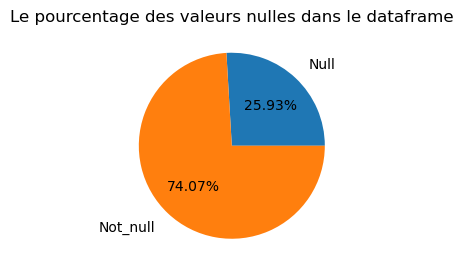

In [10]:
functions.graph_null(dataset)

In [11]:
df_null_dataset = functions.per_null_dataframe(dataset)
# Les colonnes incluent plus de 30% de valeurs manquantes
len(df_null_dataset[df_null_dataset["pourcentage_null"] >30])

253

# <a name="C4"> 2.2 Elimination des colonnes plus de 30% de valeurs manquantes </a>
<a href="#top">sommaire</a>

In [12]:
# On va supprimer ces colonnes 
def remove_columns_with_high_nulls(df, threshold=30):
    """
    Supprimez les colonnes du DataFrame qui contiennent plus qu'un pourcentage spécifié de valeurs nulles.

    :param df: DataFrame
    :param threshold: Seuil en pourcentage pour les valeurs nulles (la valeur par défaut est de 30)
    :return: DataFrame avec les colonnes spécifiées supprimées.
    """
    per_null = (df.isnull().mean() * 100).round(2)
    columns_to_remove = per_null[per_null > threshold].index
    df_cleaned = df.drop(columns=columns_to_remove)
    return df_cleaned

In [13]:
dataset_removed = remove_columns_with_high_nulls(dataset, threshold=30)
#dataset_removed = dataset_removed.drop("CODE_GENDER", axis=1)
dataset_removed.shape

(307507, 544)

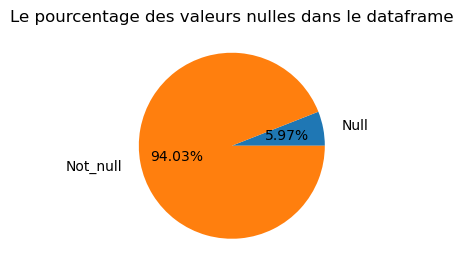

In [14]:
functions.graph_null(dataset_removed)

In [15]:
dataset_removed['TARGET'].isnull().sum()

0

In [16]:
dataset_indexed = dataset_removed.set_index('SK_ID_CURR')
dataset_indexed.head(2)

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002         1.0            0             0                0             0   
100003         0.0            1             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       25.92           1.75   
100003                        0.003541       45.93           3.25   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                   
100002                -3648.0            -2120           1               1   
100003                -1186.0             -291           1               1   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
100002                    0                 1           1           0   
100003                    0                 1           1           0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
100002                  1.0                     2   
100003                  2.0                     1   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                                2                       10   
100003                                1                       11   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                               0                           0   
100003                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                                0                       0   
100003                                0                       0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                  
100002                           0                        0      0.262949   
100003                           0                        0      0.622246   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
100002          0.139376                       2.0                       2.0   
100003               NaN                       1.0                       0.0   

            OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                       
100002                           2.0                       2.0   
100003                           1.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
100002                     -1134.0                0                1   
100003                      -828.0                0                1   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   

            FLAG_DOCUMENT_7  F

# <a name="C6"> 2.3 Séparation du dataset train et test set </a>
<a href="#top">sommaire</a>

# Splitter notre dataset

### On va définir X et y

In [17]:
X = dataset_indexed.drop('TARGET', axis=1)
y = dataset_indexed['TARGET']

### Diviser les données en ensembles d'entraînement et de test

In [18]:
from sklearn.model_selection import train_test_split
X_train_null, X_test_null, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train_null = pd.DataFrame(X_train_null, columns=X.columns, index=X_train_null.index)
X_test_null = pd.DataFrame(X_test_null, columns=X.columns, index=X_test_null.index)
print(X_train_null.shape)
print(X_test_null.shape)

(246005, 542)
(61502, 542)


In [19]:
X_train_null.head(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418                0             0                1             0   
443851                1             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
114418              315000.0   1546020.0      45333.0        1350000.0   
443851               90000.0    180000.0       9000.0         180000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418                        0.046220       39.58           2.91   
443851                        0.018029       32.95           1.46   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                   
114418                -4729.0            -4394           1               1   
443851                -3658.0            -2026           1               1   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418                    0                 1           0           0   
443851                    1                 1           0           0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
114418                  2.0                     1   
443851                  2.0                     3   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
114418                                1                       10   
443851                                3                        7   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418                               0                           0   
443851                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
114418                                0                       0   
443851                                0                       0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                  
114418                           0                        0      0.792495   
443851                           0                        0      0.556360   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418          0.497469                       0.0                       0.0   
443851               NaN                       0.0                       0.0   

            OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                       
114418                           0.0                       0.0   
443851                           0.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418                     -1658.0                0                1   
443851                      -559.0                0                0   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418                    0                0                0   
443851                    0                0                0   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9 

In [20]:
y_train.head(2)

SK_ID_CURR
114418    0.0
443851    0.0
Name: TARGET, dtype: float64

# <a name="C7"> 2.4 Imputation des données manquantes </a>
<a href="#top">sommaire</a>

## On va imputer les valeurs manquantes avec médian de chaque colonne 

In [21]:
# On va remplacer les valeurs infinies par NaN avant de procéder à une imputation
X_train_null.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_null.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X_train = imputer.fit_transform(X_train_null)
X_train = pd.DataFrame(X_train, columns=X_train_null.columns, index=X_train_null.index)
X_test = imputer.transform(X_test_null)
X_test = pd.DataFrame(X_test, columns=X_test_null.columns, index=X_test_null.index)

In [23]:
X_train.isnull().sum().sum()

0

In [24]:
X_train.describe()

CODE_GENDER   FLAG_OWN_CAR  FLAG_OWN_REALTY   CNT_CHILDREN  \
count  246005.000000  246005.000000    246005.000000  246005.000000   
mean        0.658011       0.339843         0.306762       0.416341   
std         0.474377       0.473657         0.461151       0.720894   
min         0.000000       0.000000         0.000000       0.000000   
25%         0.000000       0.000000         0.000000       0.000000   
50%         1.000000       0.000000         0.000000       0.000000   
75%         1.000000       1.000000         1.000000       1.000000   
max         1.000000       1.000000         1.000000      19.000000   

       AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count      2.460050e+05  2.460050e+05  246005.000000     2.460050e+05   
mean       1.688857e+05  5.993375e+05   27132.235282     5.385534e+05   
std        2.602985e+05  4.025214e+05   14472.153120     3.692027e+05   
min        2.565000e+04  4.500000e+04    1615.500000     4.500000e+04   
25%        1.125000e+05  2.700000e+05   16546.500000     2.385000e+05   
50%        1.485000e+05  5.147775e+05   24925.500000     4.500000e+05   
75%        2.025000e+05  8.086500e+05   34668.000000     6.795000e+05   
max        1.170000e+08  4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               246005.000000  246005.000000  246005.000000   
mean                     0.020861      43.939846       6.180004   
std                      0.013825      11.959264       5.871621   
min                      0.000290      20.520000      -0.000000   
25%                      0.010006      34.000000       2.560000   
50%                      0.018850      43.160000       4.520000   
75%                      0.028663      53.920000       7.560000   
max                      0.072508      69.120000      49.070000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
count      246005.000000    246005.000000    246005.0   246005.000000   
mean        -4987.424394     -2995.610650         1.0        0.820089   
std          3521.746270      1508.113045         0.0        0.384114   
min        -24672.000000     -7197.000000         1.0        0.000000   
25%         -7481.000000     -4299.000000         1.0        1.000000   
50%         -4504.000000     -3257.000000         1.0        1.000000   
75%         -2017.000000     -1723.000000         1.0        1.000000   
max             0.000000         0.000000         1.0        1.000000   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count    246005.000000     246005.000000  246005.000000  246005.000000   
mean          0.199211          0.998098       0.280917       0.056820   
std           0.399408          0.043575       0.449448       0.231499   
min           0.000000          0.000000       0.000000       0.000000   
25%           0.000000          1.000000       0.000000       0.000000   
50%           0.000000          1.000000       0.000000       0.000000   
75%           0.000000          1.000000       1.000000       0.000000   
max           1.000000          1.000000       1.000000       1.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    246005.000000         246005.000000                246005.000000   
mean          2.151977              2.053133                     2.032312   
std           0.909717              0.509222                     0.502915   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          20.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            246005.00

# Feature Selection

# <a name="C8"> 2.5 Elimination des colonnes 0 variance et très corrélées </a>
<a href="#top">sommaire</a>

## Supprimer les features à faible variance

Scikit-Learn propose la fonction VarianceThreshold() pour supprimer les features moins importantes. Elle utilise la variance comme critère de classement. Nous pouvons l'utiliser pour éliminer les features constantes (ayant une variance de 0, c'est-à-dire que toutes les lignes ont la même valeur) ou presque constantes (ayant une variance très faible).

In [25]:
# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0))
sel.fit(X_train)
cols_var = list(X.columns[~sel.get_support()])
print("Removed features:", cols_var)

Removed features: ['FLAG_MOBIL', 'NAME_FAMILY_STATUS_Unknown', 'BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_HouseConstruction_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN']


In [26]:
len(cols_var)

21

In [27]:
# Transform (remove low variance features)
X_train_var = sel.transform(X_train)
X_test_var = sel.transform(X_test)
X_train_var = pd.DataFrame(X_train_var, columns=X_train.drop(cols_var, axis=1).columns, index=X_train.index)
X_test_var = pd.DataFrame(X_test_var, columns=X_train.drop(cols_var, axis=1).columns, index=X_test.index)
print(X_train_var.shape)
print(X_test_var.shape)

(246005, 521)
(61502, 521)


In [28]:
X_train_var.head(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418              0.0           0.0              1.0           0.0   
443851              1.0           0.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
114418              315000.0   1546020.0      45333.0        1350000.0   
443851               90000.0    180000.0       9000.0         180000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418                        0.046220       39.58           2.91   
443851                        0.018029       32.95           1.46   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
114418                -4729.0          -4394.0             1.0   
443851                -3658.0          -2026.0             1.0   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418                  0.0               1.0         0.0         0.0   
443851                  1.0               1.0         0.0         0.0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
114418                  2.0                   1.0   
443851                  2.0                   3.0   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
114418                              1.0                     10.0   
443851                              3.0                      7.0   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418                             0.0                         0.0   
443851                             0.0                         0.0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
114418                              0.0                     0.0   
443851                              0.0                     0.0   

            REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                  
114418                         0.0                      0.0      0.792495   
443851                         0.0                      0.0      0.556360   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418          0.497469                       0.0                       0.0   
443851          0.537070                       0.0                       0.0   

            OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                       
114418                           0.0                       0.0   
443851                           0.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418                     -1658.0              0.0              1.0   
443851                      -559.0              0.0              0.0   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418                  0.0              0.0              0.0   
443851                  0.0              0.0              0.0   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                   

## Supprimer les features fortement corrélés

Scikit-Learn fournit des fonctions qui nous permettent de calculer et de visualiser les corrélations entre nos features.Scikit-Learn ne propose pas de fonction spécifique pour supprimer les features fortement corrélés, nous devons donc écrire du code pour le faire. Voici une fonction qui trouve les features fortement corrélés à d'autres features dans un ensemble de données.

In [29]:
# Fonction pour répertorier les features qui sont corrélés
# Ajoute seulement le premier de la paire corrélée (et non les deux)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

In [30]:
# Obtenir un ensemble de features corrélés, en fonction d'une corrélation seuil de 0,80.
cf = correlatedFeatures(X_train_var, 0.80)
cf

{'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_CNT_CREDIT_PROLONG_SUM',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'AMT_GOODS_PRICE',
 'APPROVED_AMT_ANNUITY_MAX',
 'APPROVED_AMT_ANNUITY_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'APPROVED_AMT_APPLICATION_MAX',
 'APPROVED_AMT_APPLICATION_MEAN',
 'APPROVED_AMT_APPLICATION_MIN',
 'APPROVED_AMT_CREDIT_MAX',
 'APPROVED_AMT_CREDIT_MEAN',
 'APPROVED_AMT_CREDIT_MIN',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MIN',
 'APPROVED_AMT_GOODS_PRICE_MAX',
 'APPROVED_AMT_GOODS_PRICE_MEAN',
 'APPROVED_AMT_GOODS_PRICE_MIN',
 'APPROVED_APP_CREDIT_PERC_MAX',
 'APPROVED_APP_CREDIT_PERC_MEAN',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'APPROVED_DAYS_DECISION_MAX',
 'APPROVED_

In [31]:
len(cf)

112

In [32]:
# Remove the correlated features
X_train_corr = X_train_var.drop(cf, axis=1)
X_test_corr = X_test_var.drop(cf, axis=1)
print(X_train_corr.shape)
print(X_test_corr.shape)

(246005, 409)
(61502, 409)


In [33]:
cols_train = X_train_corr.columns
cols_test = X_test_corr.columns

# <a name="C9"> 2.6 Standard Scaling </a>
<a href="#top">sommaire</a>

### On va mettre à l'échelle(scaler) les colonnes

In [34]:
scaler =  StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_corr)
X_test_scaled = scaler.transform(X_test_corr)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols_train, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols_test, index=X_test.index)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(246005, 409)
(61502, 409)


In [35]:
X_test_scaled.head(3)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343913         0.720924     -0.717489        -0.665211     -0.577535   
281768         0.720924     -0.717489        -0.665211     -0.577535   
215345         0.720924     -0.717489        -0.665211      0.809633   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
343913             -0.216620    0.387191     0.644464   
281768             -0.216620    1.199632     0.320462   
215345             -0.130181   -0.747354    -0.496384   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
343913                       -1.026464    0.991715      -0.282717   
281768                       -1.283180   -0.979982      -0.345732   
215345                       -0.084811   -0.959078      -0.802166   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
343913               1.068059        -0.543985       -2.135019   
281768               1.253195        -0.081154        0.468380   
215345               1.303170         1.066640        0.468380   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
343913            -0.498768          0.043658   -0.625028   -0.245444   
281768            -0.498768          0.043658    1.599928   -0.245444   
215345             2.004942          0.043658   -0.625028   -0.245444   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
343913                 -0.104342                 0.899170   
281768                  1.859443                -0.630415   
215345                 -0.104342                -1.242249   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
343913                       -0.123809                   -0.231497   
281768                       -0.123809                   -0.231497   
215345                       -0.123809                   -0.231497   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
343913                   -0.291159               -0.547714      0.030433   
281768                   -0.291159               -0.547714      0.360033   
215345                   -0.291159                1.825771     -0.158852   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
343913          0.118993                 -0.587593                 -0.319781   
281768          0.883285                 -0.172953                 -0.319781   
215345          0.118993                 -0.587593                 -0.319781   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
343913                    0.372526         -0.00727        -1.563268   
281768                    0.423330         -0.00727         0.639685   
215345                    0.824919         -0.00727         0.639685   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
343913            -0.008789         -0.12472         3.208339   
281768            -0.008789         -0.12472        -0.311688   
215345            -0.008789         -0.12472        -0.311688   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
343913            -0.013375        -0.298182        -0.062885   
2

# <a name="C10"> 2.7 Traitement du déséquilibre des classes </a>
<a href="#top">sommaire</a>

On constate clairement un déséquilibre dans notre variable cible, avec seulement 8% de la classe 1 (clients non solvables) par rapport à 92% de la classe 0 (clients solvables). Pour éviter d'obtenir des résultats biaisés, nous allons explorer différentes techniques pour équilibrer les données et comparer les résultats avec les données d'origine.

**RandomUnderSampler :** une technique de sous-échantillonnage qui vise à équilibrer les classes en réduisant le nombre d'instances de la classe majoritaire. Il supprime aléatoirement des échantillons de la classe majoritaire jusqu'à atteindre un équilibre entre les classes.

**SMOTE :** une technique de suréchantillonnage qui vise à équilibrer les classes en créant des échantillons synthétiques de la classe minoritaire. Cela augmente la taille de la classe minoritaire et peut améliorer la performance du modèle en réduisant le biais.

**Model(class_weight="balanced") :** l'utilisation de l'argument class_weight="balanced" lors de la création d'un modèle, cela signifie que le modèle attribuera automatiquement des poids plus importants aux classes minoritaires pendant l'entraînement, réduisant ainsi l'impact du déséquilibre sur la performance du modèle.

# Equilibrage

In [37]:
df_correlation = X_train_corr.copy()
df_correlation["TARGET"] = y_train
df_correlation.head(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
114418              0.0           0.0              1.0           0.0   
443851              1.0           0.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
114418              315000.0   1546020.0      45333.0   
443851               90000.0    180000.0       9000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
114418                        0.046220       39.58           2.91   
443851                        0.018029       32.95           1.46   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
114418                -4729.0          -4394.0             1.0   
443851                -3658.0          -2026.0             1.0   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
114418                  0.0               1.0         0.0         0.0   
443851                  1.0               1.0         0.0         0.0   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
114418                       1.0                     10.0   
443851                       3.0                      7.0   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
114418                             0.0                         0.0   
443851                             0.0                         0.0   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
114418                         0.0                     0.0      0.792495   
443851                         0.0                     0.0      0.556360   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
114418          0.497469                       0.0                       0.0   
443851          0.537070                       0.0                       0.0   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
114418                     -1658.0              0.0              1.0   
443851                      -559.0              0.0              0.0   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
114418                  0.0              0.0              0.0   
443851                  0.0              0.0              0.0   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
114418                  0.0              0.0              0.0   
443851                  0.0              0.0              0.0   

            FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  \
SK_ID_CURR                                                         
114418                   0.0               0.0               0.0   
443851                   0.0               0.0               0.0   

            FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
SK_ID_CURR                                                         
114418                   0.0               0.0               0.0   
443851                   0.0               0.0               0.0   

            FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
SK_ID_CURR                                                         
114418        

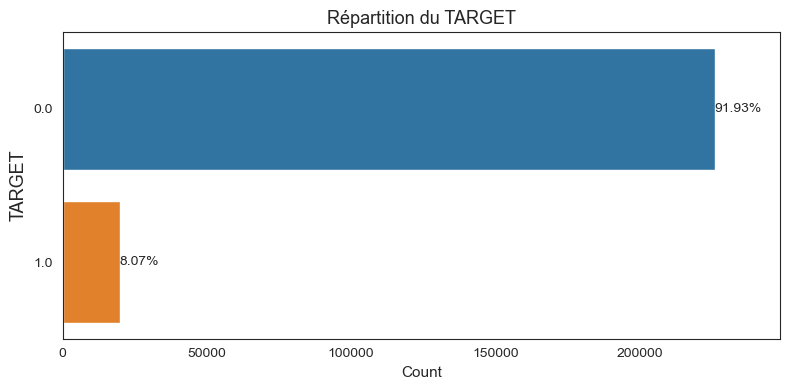

In [38]:
plt.style.use('default')
functions.countplot(df_correlation, "TARGET", figsize=(8, 4))

In [39]:
# Under sampling
undersample = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_unders, y_unders = undersample.fit_resample(X_train_scaled, y_train)
print("Before using RandomUnderSampler:", Counter(y_train))
print("Under sampled dataset shape", Counter(y_unders))

# Over sampling
oversample = SMOTE(random_state=42)
X_overs, y_overs = oversample.fit_resample(X_train_scaled, y_train)
print("Before using SMOTE:", Counter(y_train))
print("Over sampled dataset shape", Counter(y_overs))

Before using RandomUnderSampler: Counter({0.0: 226145, 1.0: 19860})
Under sampled dataset shape Counter({0.0: 19860, 1.0: 19860})
Before using SMOTE: Counter({0.0: 226145, 1.0: 19860})
Over sampled dataset shape Counter({0.0: 226145, 1.0: 226145})


# <a name="C5"> 3.1 Modélisation et évaluation des différents modèles </a>
<a href="#top">sommaire</a>

# <a name="C11"> 3.2 Les métriques d'évaluation et le score métier </a>
<a href="#top">sommaire</a>

**La fonction de coût métier:** On a le déséquilibre du coût métier entre un faux négatif et un faux positif. Donc on a créé un score métier en basant matrice de confusion pour pénaliser plus des faux négatifs.

FN - mauvais client prédit bon client : donc crédit accordé et perte en capital

FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge

TN - mauvais client prédit mauvais client : donc refus crédit et pas perte

TP - bon client prédit bon : donc crédit accordé et pas perte

In [40]:
def fonction_metier(y_test, y_pred):
   
    
    coeff_tp = 0      # Vrais positifs
    coeff_fp = -1     # Faux positifs 
    coeff_fn = -10    # Faux négatifs 
    coeff_tn = 0      # Vrais négatifs
    
    (tn, fp, fn, tp) = metrics.confusion_matrix(y_test, y_pred).ravel()
    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)
    
    # Calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent.
    # C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp
    
    # Calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent.
    # C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn
    # Normalisation  : score= (tot-min)/(max-min) 
    gain = (total - min_gain) / (max_gain - min_gain)   
    return gain

In [41]:
from sklearn.metrics import make_scorer

cost_scorer = make_scorer(fonction_metier, greater_is_better=True)

In [42]:
def conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize):
    '''Fonction pour plotting Confusion Matrix et ROC Curve.'''
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Confusion Matrix
    ax1 = axes[0]
    ax1.set_title('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax1, annot_kws={"size": 18})
    ax1.set_ylabel('True Label', fontsize=18)  # Increase font size for ylabel
    ax1.set_xlabel('Predicted Label', fontsize=18)  # Increase font size for xlabel
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # ROC Curve
    ax2 = axes[1]
    ax2.set_title('ROC Curve')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='steelblue', linewidth=5, label=f'AUC = {auc:.2f}', markersize=18)
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    ax2.set_xlabel('False Positive Rate', fontsize=18)  
    ax2.set_ylabel('True Positive Rate', fontsize=18) 
    ax2.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

    return cf_matrix

 On a évalué nos modèles en utilisant le score métier, mais on a également examiné les métriques suivantes.

**Accuracy :** mesure combien de prédictions correctes le modèle a fait dans l'ensemble des prédictions. C'est un indicateur global de la performance d'un modèle, mais il peut être trompeur en présence de classes déséquilibrées. 

**Precision :** elle est calculée en divisant le nombre d'observations correctement prédites comme positives par le nombre total d'observations prédites comme positives. La précision est utile lorsque les faux positifs sont coûteux.

**Recall :** il est calculé en divisant le nombre d'observations correctement prédites comme positives parmi toutes les véritables observations positives. Le rappel est important lorsque les faux négatifs sont coûteux.

**F1-Score :** est une métrique qui combine à la fois la précision et le rappel en une seule valeur. Il est particulièrement utile en cas de déséquilibre entre les classes.

**ROC AUC Score :** Le score AUC-ROC mesure la capacité d'un modèle à distinguer entre les classes en utilisant la courbe ROC. Il calcule l'aire sous la courbe ROC, qui varie de 0 à 1.


In [43]:
def evaluation_score(model, X_train, y_train, X_test, y_test, model_name, figsize):
    '''
    Calculez, affichez et enregistrez différentes métriques.

        :param model: Le modèle d'apprentissage automatique à évaluer.
        :param X_train: Données d'entraînement.
        :param y_train: Étiquettes cibles pour les données d'entraînement.
        :param X_test: Données de test.
        :param y_test: Vraies étiquettes pour les données de test.
        :param figsize: Tuple spécifiant la taille de la figure pour la courbe ROC.
        :param model_name: Nom du modèle (pour le DataFrame de résultats).
        :return: Un DataFrame avec les métriques.
    '''
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time
    execution_time = round(execution_time,3)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metier = fonction_metier(y_test, y_pred).round(2)
    accuracy = metrics.accuracy_score(y_test, y_pred).round(2)
    precision = metrics.precision_score(y_test, y_pred).round(2)
    recall = metrics.recall_score(y_test, y_pred).round(2)
    f1_score = metrics.f1_score(y_test, y_pred).round(2)
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    
    # Display classification report
    print(classification_report(y_test, y_pred))
    
    # Display confusion matrix and ROC curve
    conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize)
    
    # Create a DataFrame with rounded metrics
    results = pd.DataFrame({'model': [model_name],
                            'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1_score': [f1_score],
                            'roc_auc_score': [auc_score],
                            'custom_score': [metier],
                            'execution_time': [execution_time]})
    display(results)
    
    return results, accuracy, precision, recall, f1_score, auc_score, metier

In [44]:
mlflow.set_tracking_uri("/Users/zeyneperdem/Desktop/ds_prep/p7/mlruns")

In [45]:
tracking_uri = mlflow.get_tracking_uri()

In [46]:
tracking_uri

'/Users/zeyneperdem/Desktop/ds_prep/p7/mlruns'

In [47]:
from mlflow.models.signature import infer_signature

In [48]:
def mlfow_track(exp_name, model, X_train, y_train, X_test, y_test, model_name, figsize):
    model = model
    signature = infer_signature(X_train, y_train)
    plt.style.use('fivethirtyeight')
    mlflow.set_experiment(exp_name)
    mlflow.sklearn.autolog()
    mlflow.lightgbm.autolog()
    with mlflow.start_run(run_name=exp_name):
        model.fit(X_train, y_train)
        results, accuracy, precision, recall, f1_score, auc_score,\
        metier = evaluation_score(model, X_train, y_train, X_test, y_test, model_name, figsize) 
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("custom_score", metier)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("rocauc", auc_score)
    return model, results

# <a name="C12"> 3.3 Evaluation des différents modèles </a>
<a href="#top">sommaire</a>

### Les différents modèles testés

Les modèles ont été évalués en utilisant l'ensemble de données de 409 colonnes sur les ensembles d'entraînement et de test. Les résultats ont été comparés en utilisant diverses métriques d'évaluation, notamment le score métier. Le meilleur modèle (Lgbm) a été sélectionné, et les 10 features les plus importantes pour ce modèle ont été identifiées. Ensuite, un GridSearchCV a été utilisé pour optimiser les hyperparamètres de ce modèle.

**DummyClassifier:** un modèle simple utilisé comme point de référence. Il attribue des prédictions en utilisant des règles simples, comme le choix de la classe majoritaire dans notre cas.

**Régression Logistique :** un algorithme de classification qui utilise une fonction logistique.Elle modélise la probabilité d'une observation appartienne à une classe particulière.

**Random Forest :** un modèle d'ensemble basé sur les arbres de décision. Il combine plusieurs arbres de décision pour améliorer la précision de la prédiction et réduire le surajustement. Chaque arbre est construit sur un échantillon aléatoire des données et des caractéristiques.

**Light GBM :** un algorithme de boosting qui utilise une méthode d'entraînement en gradient, similaire à d'autres méthodes de boosting. Cependant, il se distingue par sa vitesse et son efficacité. Il est souvent utilisé pour des ensembles de données de grande taille et offre des performances exceptionnelles.

# DummyClassifier

In [49]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy='most_frequent')

## Avec data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



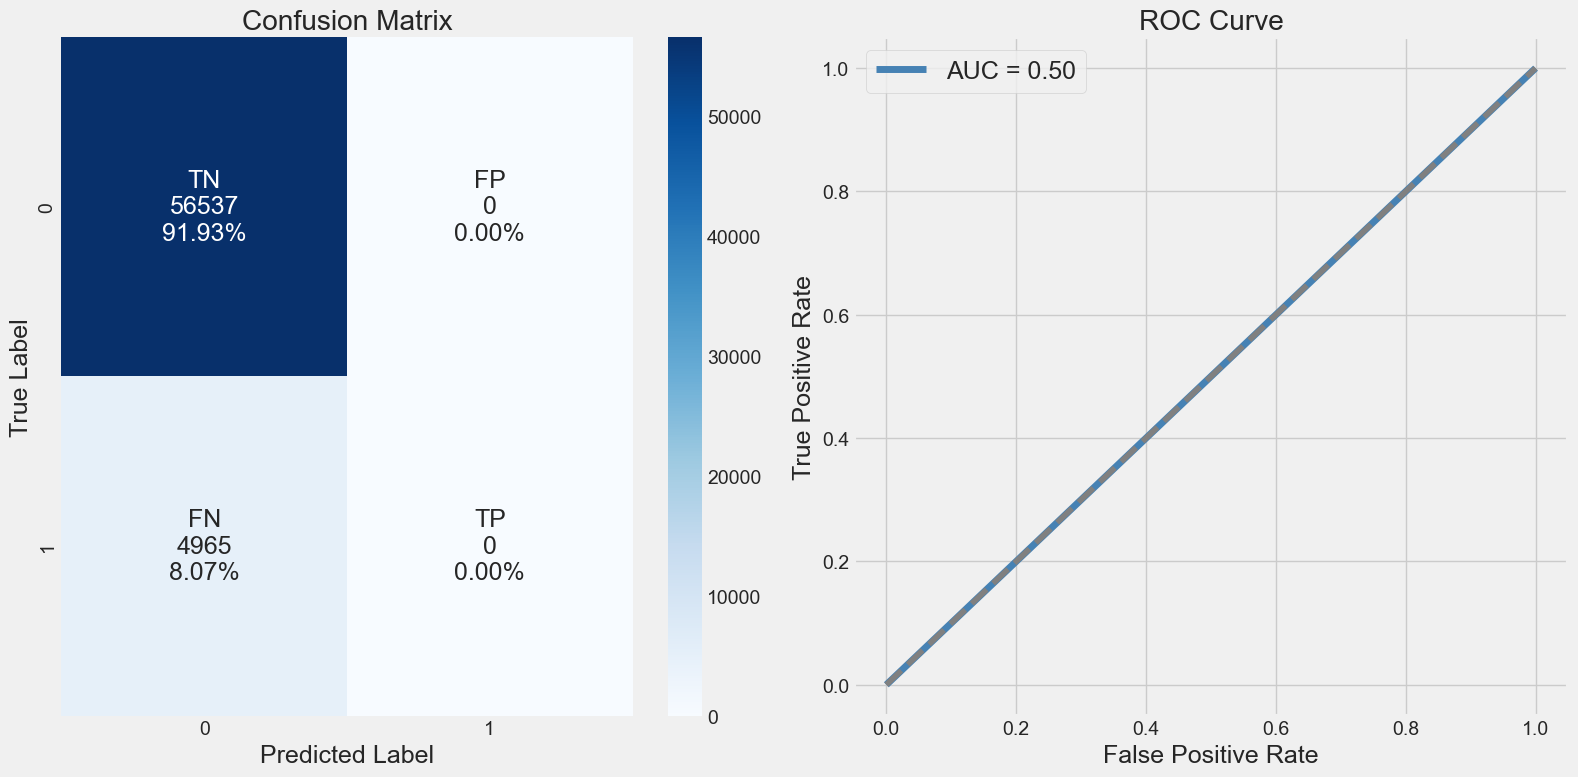

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  dummy_origine      0.92        0.0     0.0       0.0            0.5   

   custom_score  execution_time  
0          0.53           8.687

In [50]:
model = DummyClassifier(strategy='most_frequent')
dummy_origine, results_dummy_origine = mlfow_track("dummy_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "dummy_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



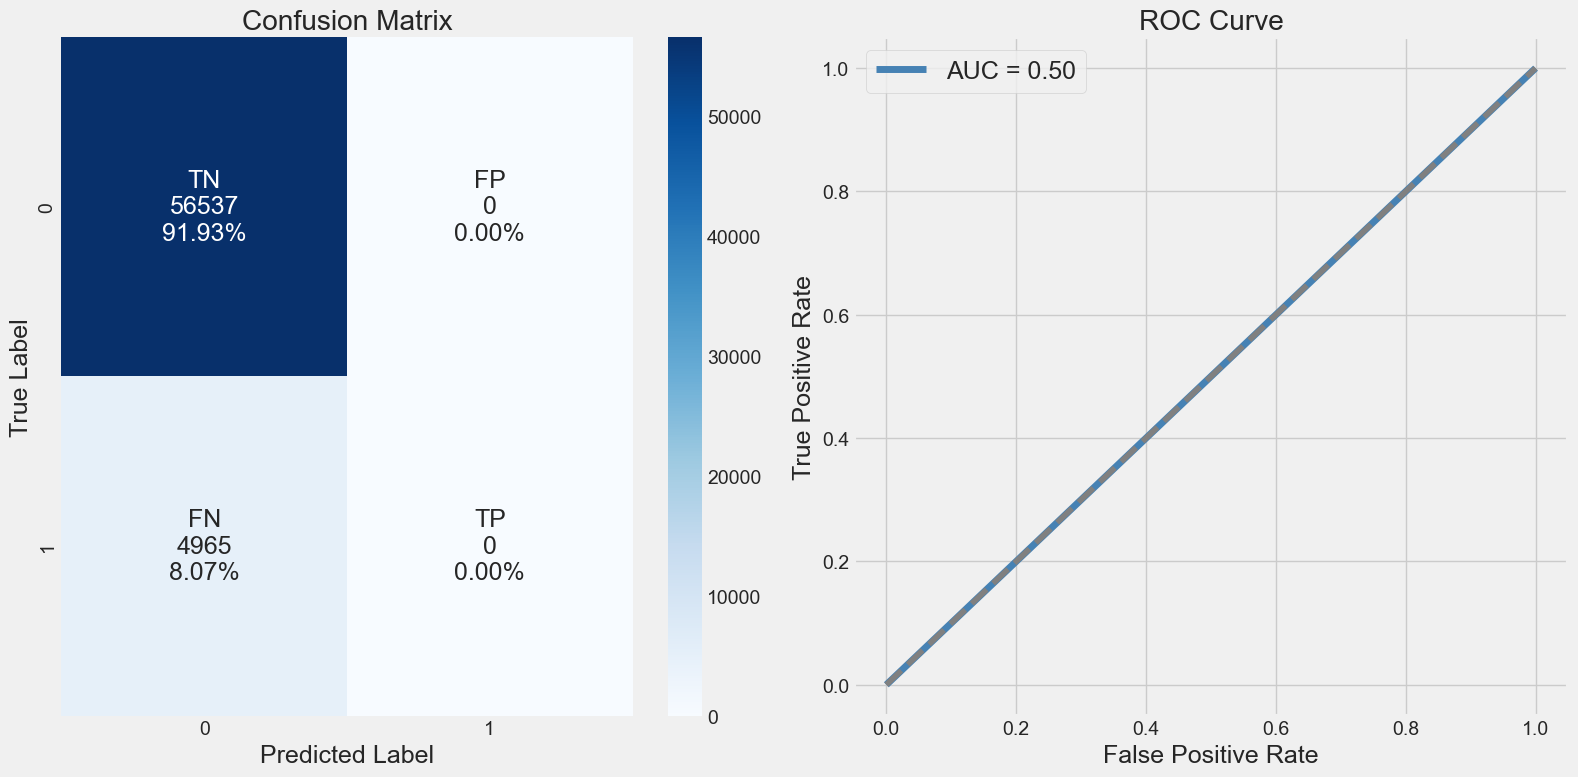

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  dummy_unders      0.92        0.0     0.0       0.0            0.5   

   custom_score  execution_time  
0          0.53           2.529

In [51]:
model = DummyClassifier(strategy='most_frequent')
dummy_unders, results_dummy_unders = mlfow_track("dummy_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "dummy_unders", (16,8))

# Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



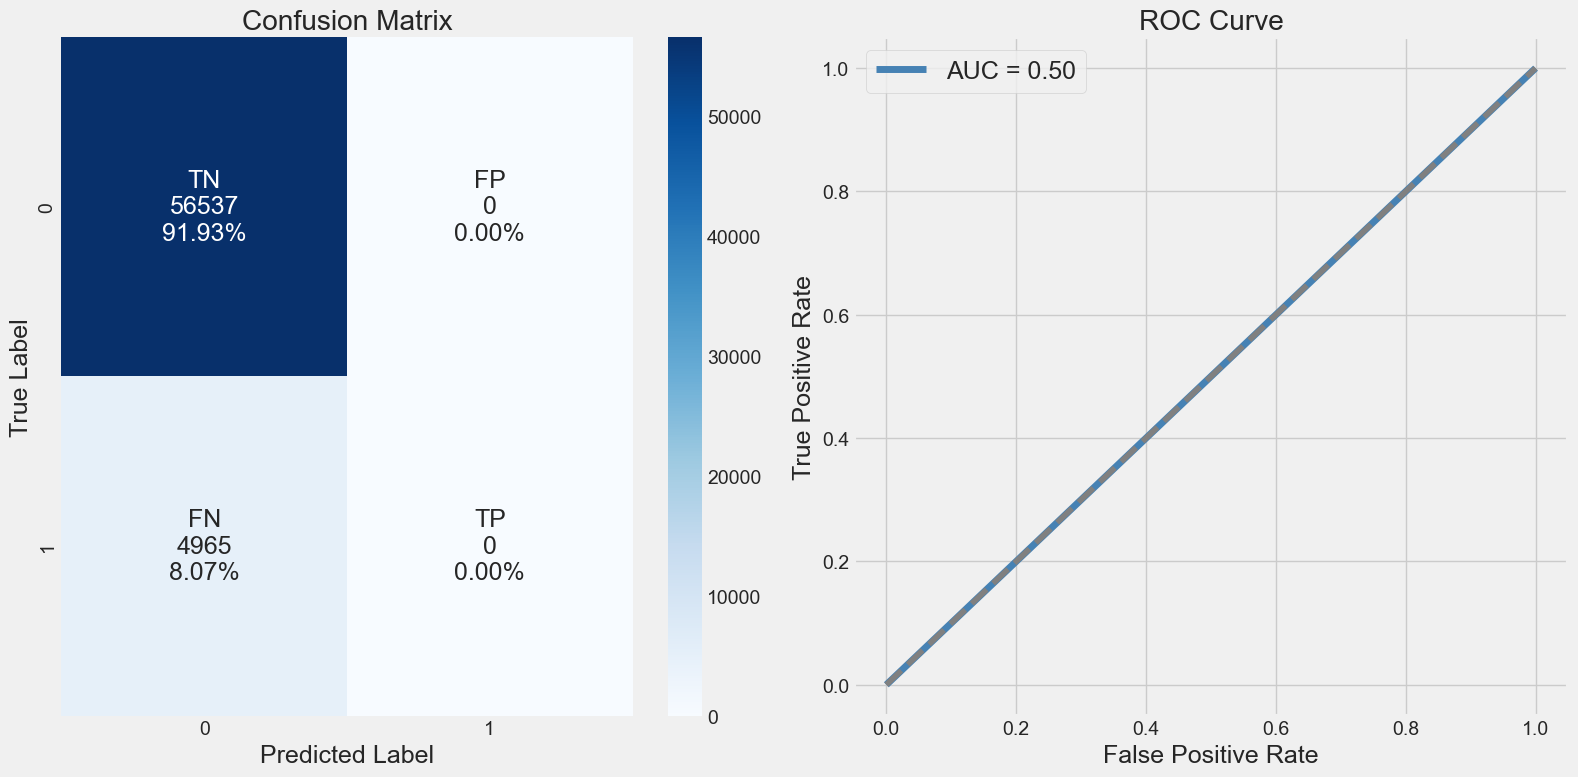

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  dummy_overs      0.92        0.0     0.0       0.0            0.5   

   custom_score  execution_time  
0          0.53          16.852

In [52]:
model = DummyClassifier(strategy='most_frequent')
dummy_overs, results_dummy_overs = mlfow_track("dummy_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "dummy_overs", (16,8))

## Comparaison des résultas DummyClassifier

In [53]:
comp_dummy = pd.concat([results_dummy_origine, results_dummy_unders, results_dummy_overs], axis=0)
comp_dummy

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  dummy_origine      0.92        0.0     0.0       0.0            0.5   
0   dummy_unders      0.92        0.0     0.0       0.0            0.5   
0    dummy_overs      0.92        0.0     0.0       0.0            0.5   

   custom_score  execution_time  
0          0.53           8.687  
0          0.53           2.529  
0          0.53          16.852

# Logistic Regression

## Avec data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.50      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



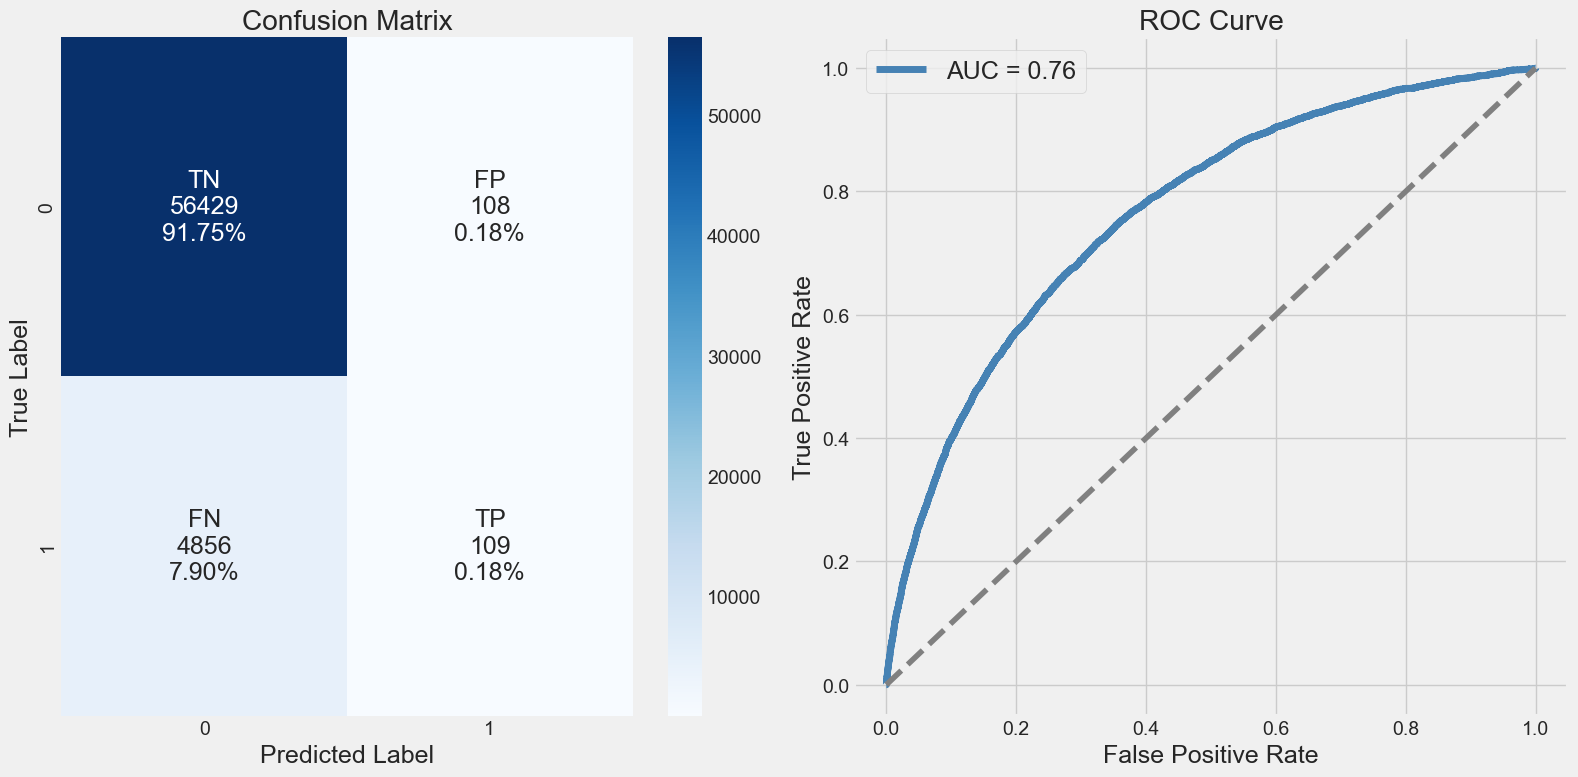

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_origine      0.92        0.5    0.02      0.04           0.76   

   custom_score  execution_time  
0          0.54          17.569

In [54]:
model = LogisticRegression(random_state=42)
lr_origine, results_lr_origine = mlfow_track("lr_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lr_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



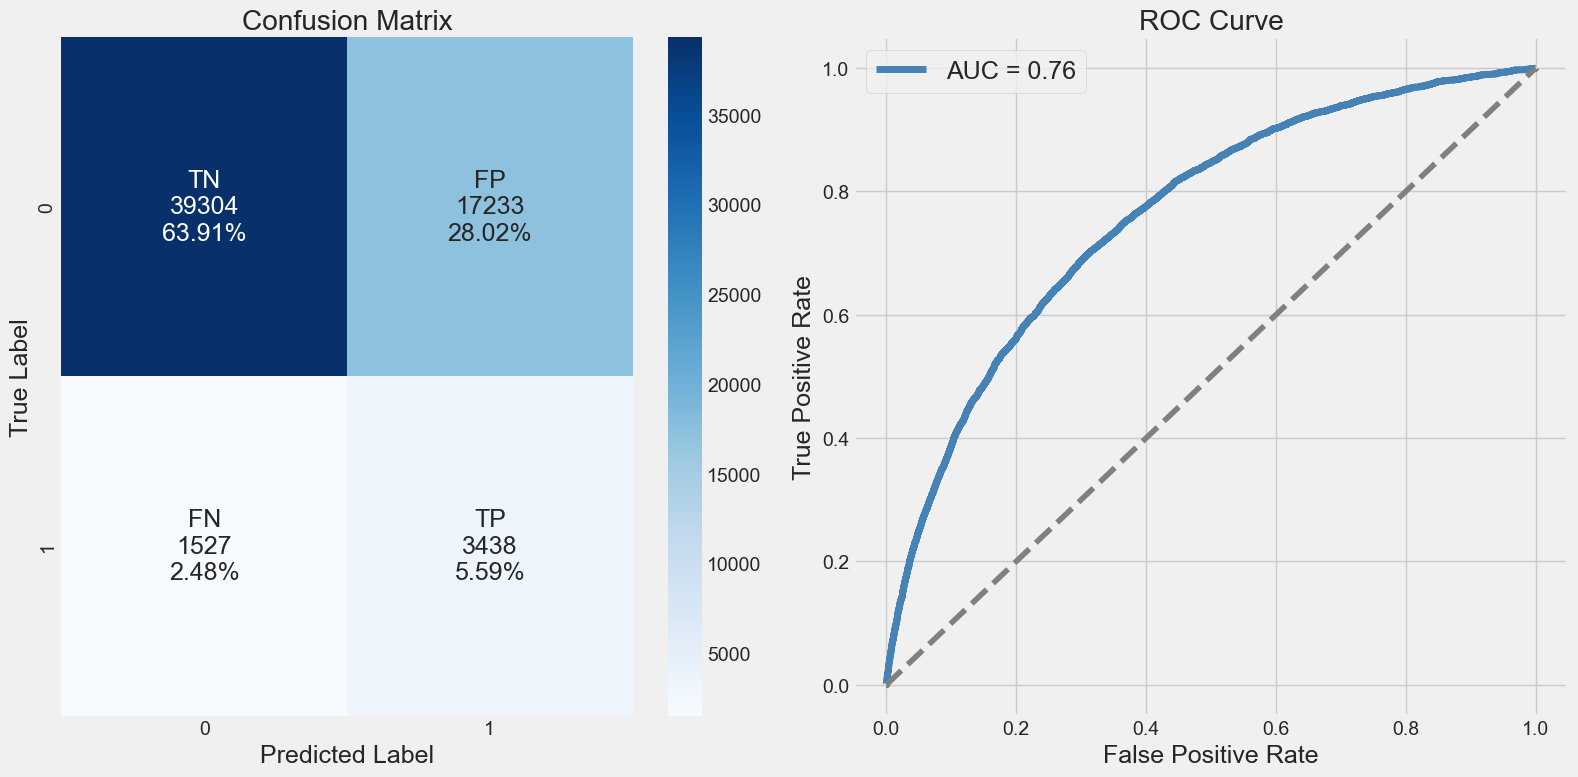

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_unders      0.69       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.69           4.133

In [55]:
model = LogisticRegression(random_state=42)
lr_unders, results_lr_unders = mlfow_track("lr_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "lr_unders", (16,8))

In [56]:
lr_unders

LogisticRegression(random_state=42)

In [57]:
results_lr_unders

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_unders      0.69       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.69           4.133

# Oversampled

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56537
         1.0       0.17      0.65      0.26      4965

    accuracy                           0.71     61502
   macro avg       0.56      0.68      0.54     61502
weighted avg       0.89      0.71      0.77     61502



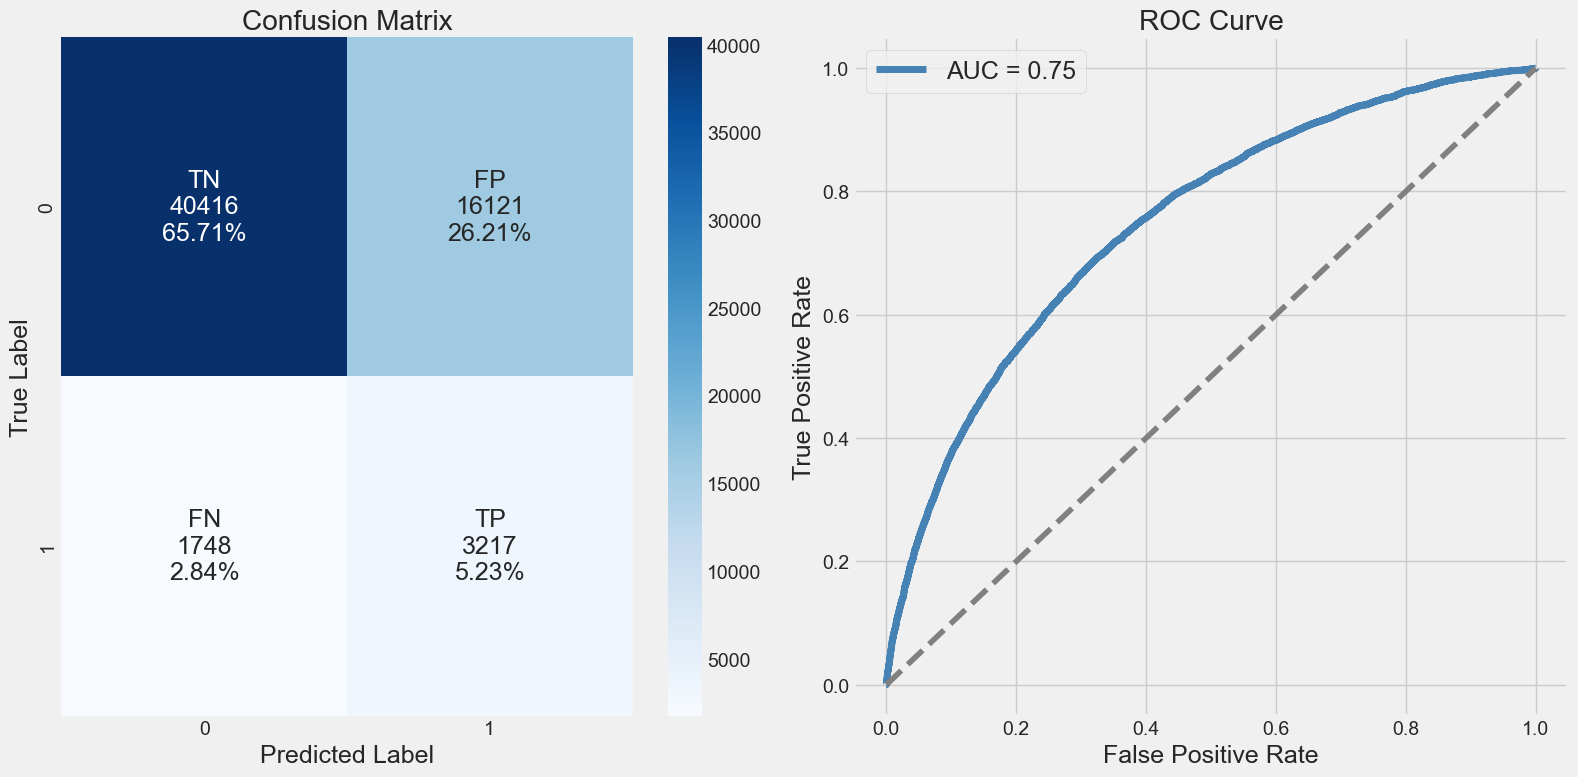

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_overs      0.71       0.17    0.65      0.26           0.75   

   custom_score  execution_time  
0          0.68          31.227

In [58]:
model = LogisticRegression(random_state=42)
lr_overs, results_lr_overs = mlfow_track("lr_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "lr_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



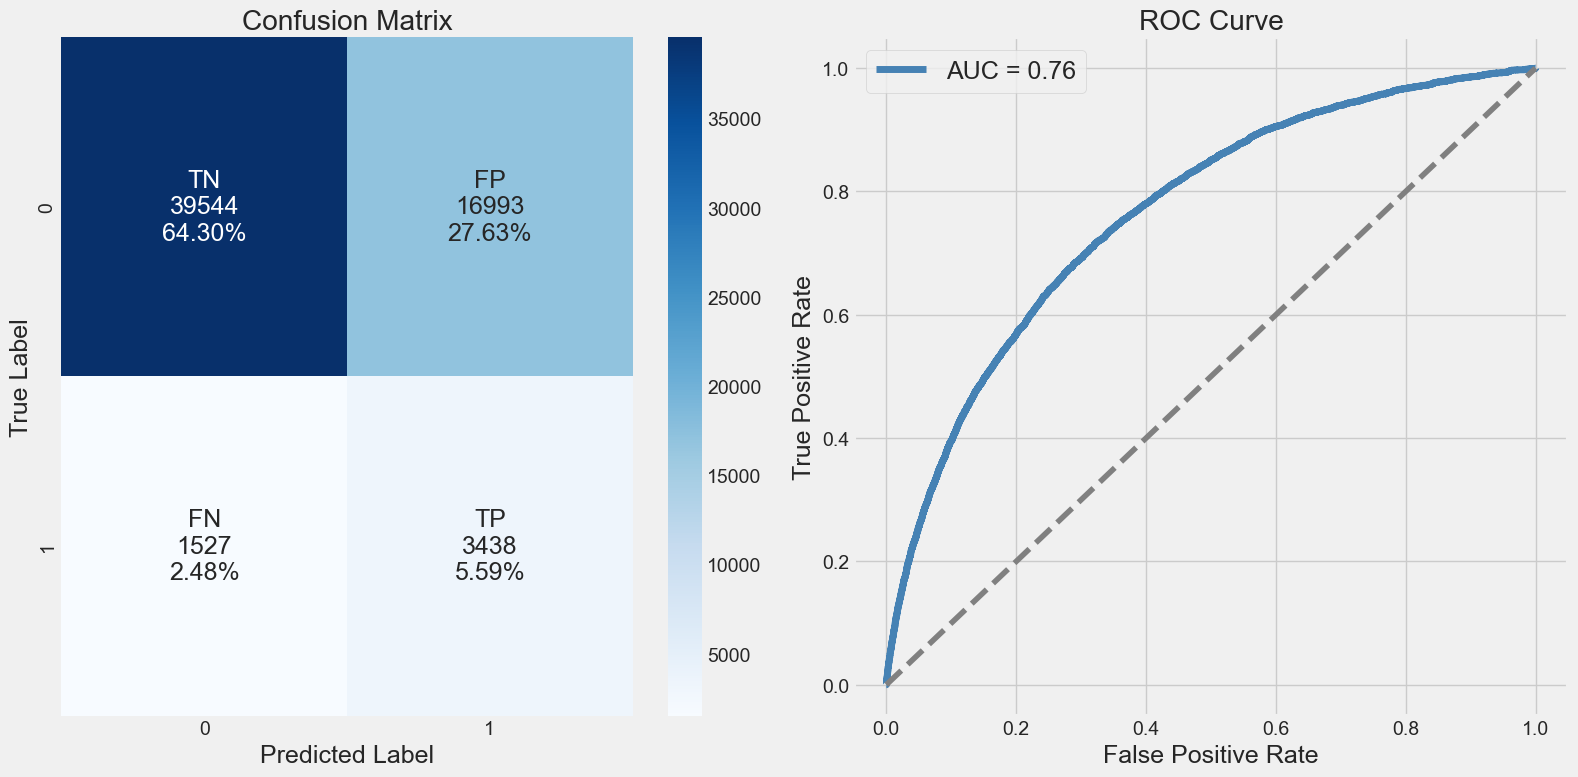

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lr_balanced       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0           0.7          16.736

In [59]:
model = LogisticRegression(random_state=42, class_weight="balanced")
lr_balanced, results_lr_balanced = mlfow_track("lr_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lr_balanced", (16,8))

## Comparaison des résultas Logistic Regression

In [60]:
comp_lr = pd.concat([results_lr_origine, results_lr_unders, results_lr_overs, results_lr_balanced], axis=0)
comp_lr

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lr_origine      0.92       0.50    0.02      0.04           0.76   
0    lr_unders      0.69       0.17    0.69      0.27           0.76   
0     lr_overs      0.71       0.17    0.65      0.26           0.75   
0  lr_balanced      0.70       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.54          17.569  
0          0.69           4.133  
0          0.68          31.227  
0          0.70          16.736

# Random Forest

# Data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.78      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.85      0.50      0.48     61502
weighted avg       0.91      0.92      0.88     61502



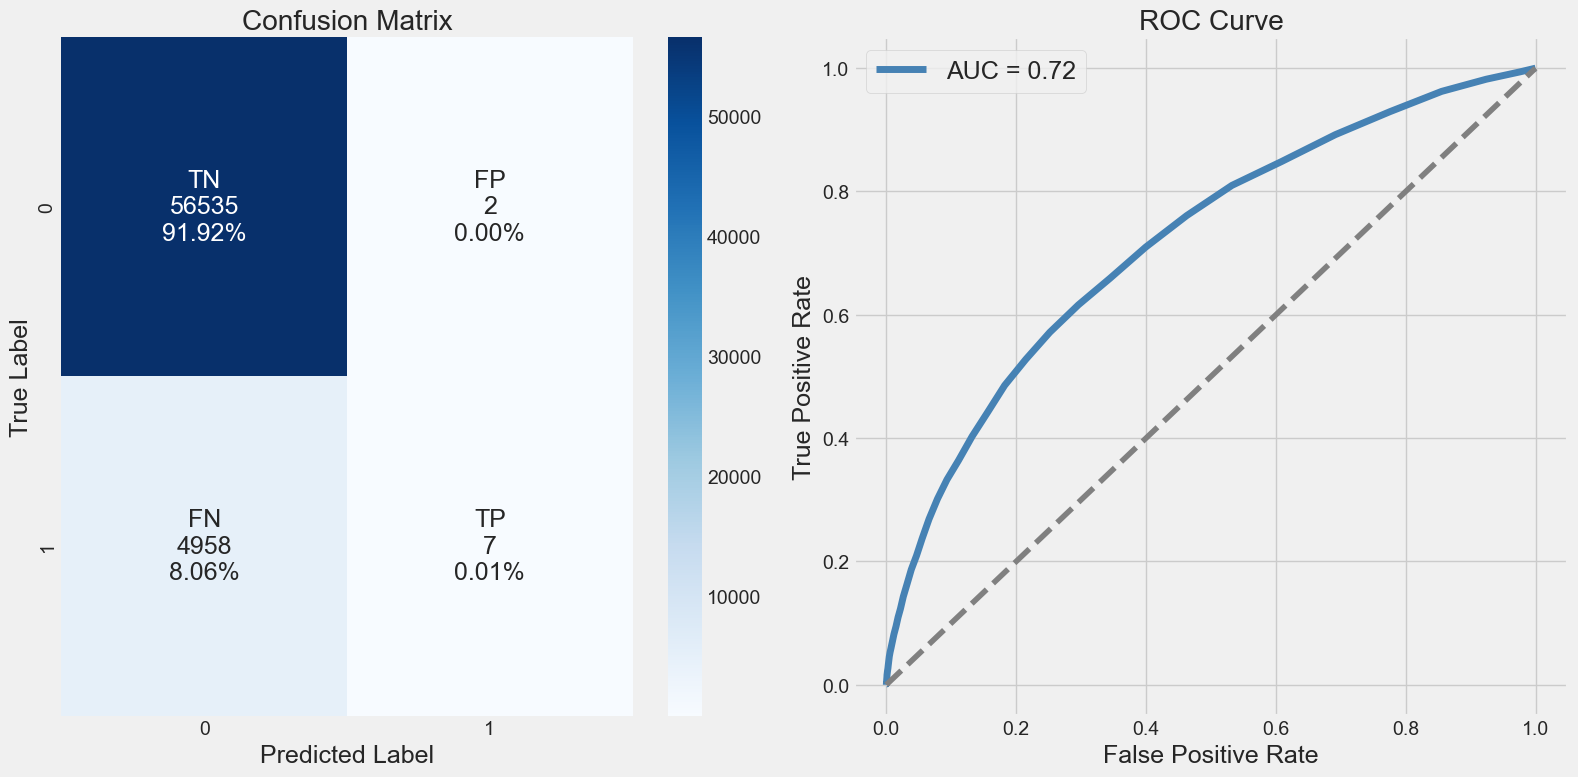

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_origine      0.92       0.78     0.0       0.0           0.72   

   custom_score  execution_time  
0          0.53         169.385

In [61]:
model = RandomForestClassifier(random_state=42)
rf_origine, results_rf_origine = mlfow_track("rf_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "rf_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56537
         1.0       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



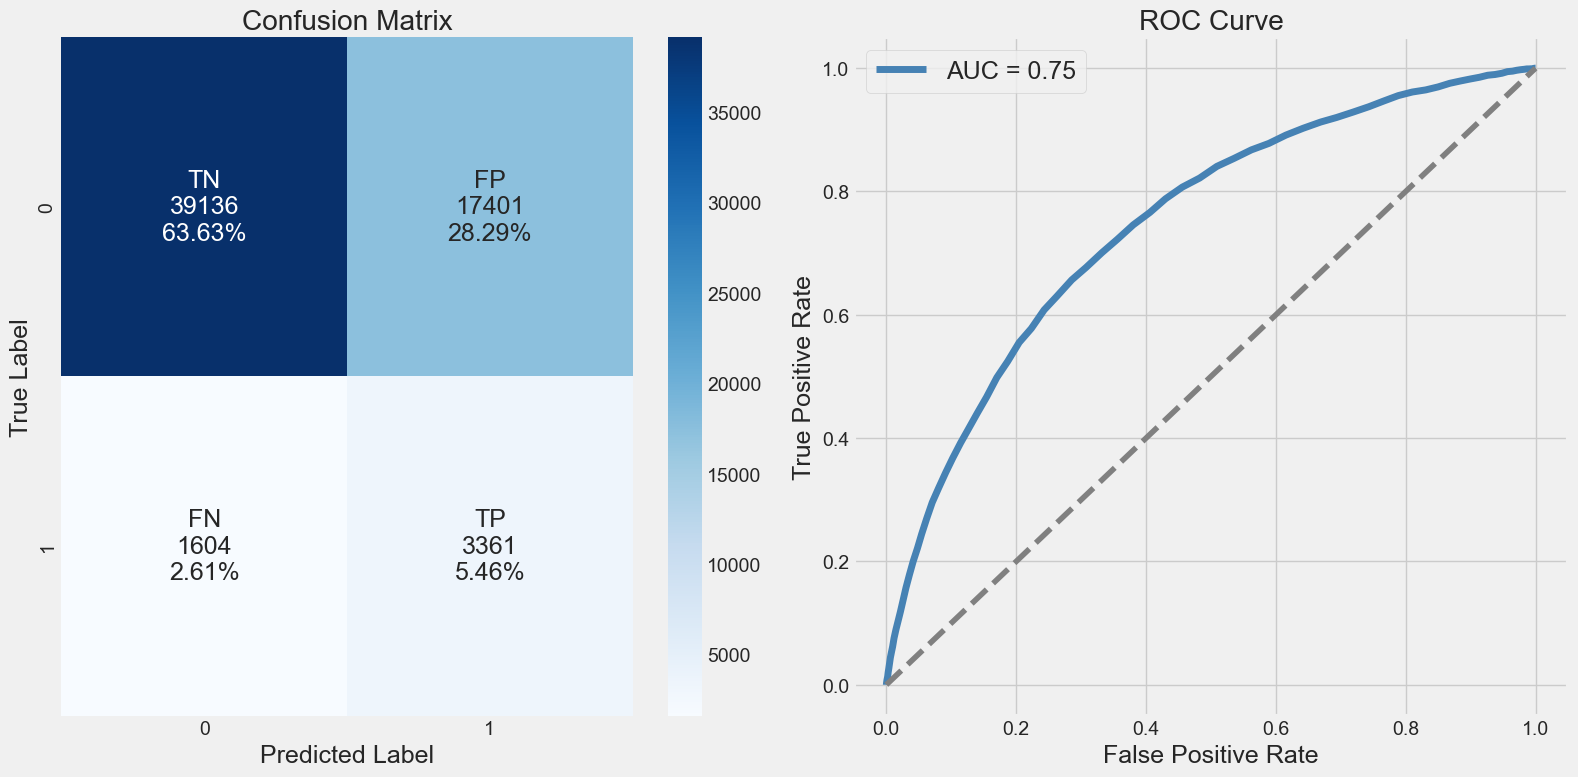

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_unders      0.69       0.16    0.68      0.26           0.75   

   custom_score  execution_time  
0          0.69          20.042

In [62]:
model = RandomForestClassifier(random_state=42)
rf_unders, results_rf_unders = mlfow_track("rf_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "rf_unders", (16,8))

## Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.35      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.63      0.51      0.50     61502
weighted avg       0.87      0.92      0.88     61502



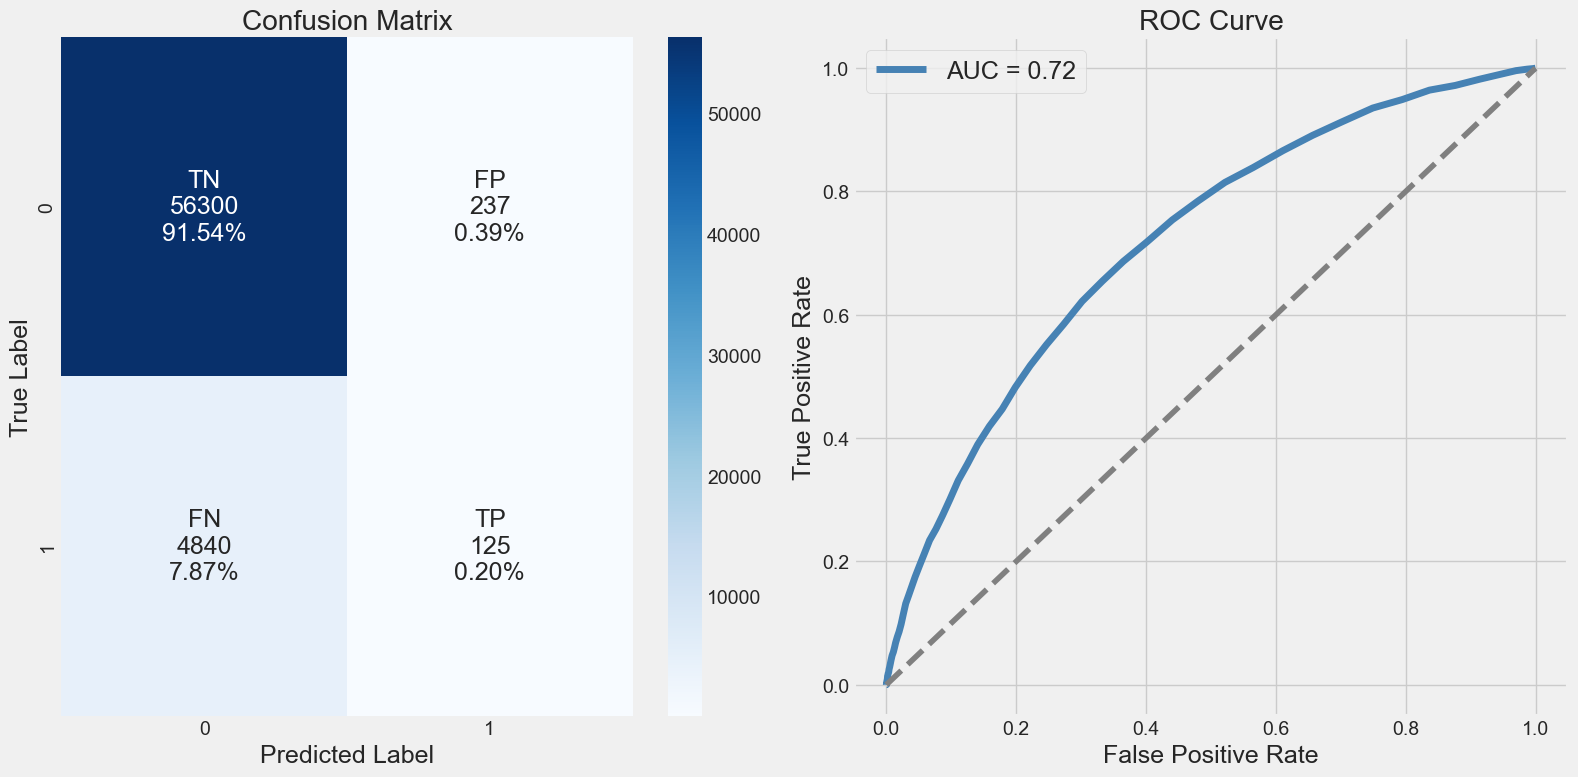

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_overs      0.92       0.35    0.03      0.05           0.72   

   custom_score  execution_time  
0          0.54          313.59

In [63]:
model = RandomForestClassifier(random_state=42)
rf_overs, results_rf_overs = mlfow_track("rf_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "rf_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.59      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.75      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502



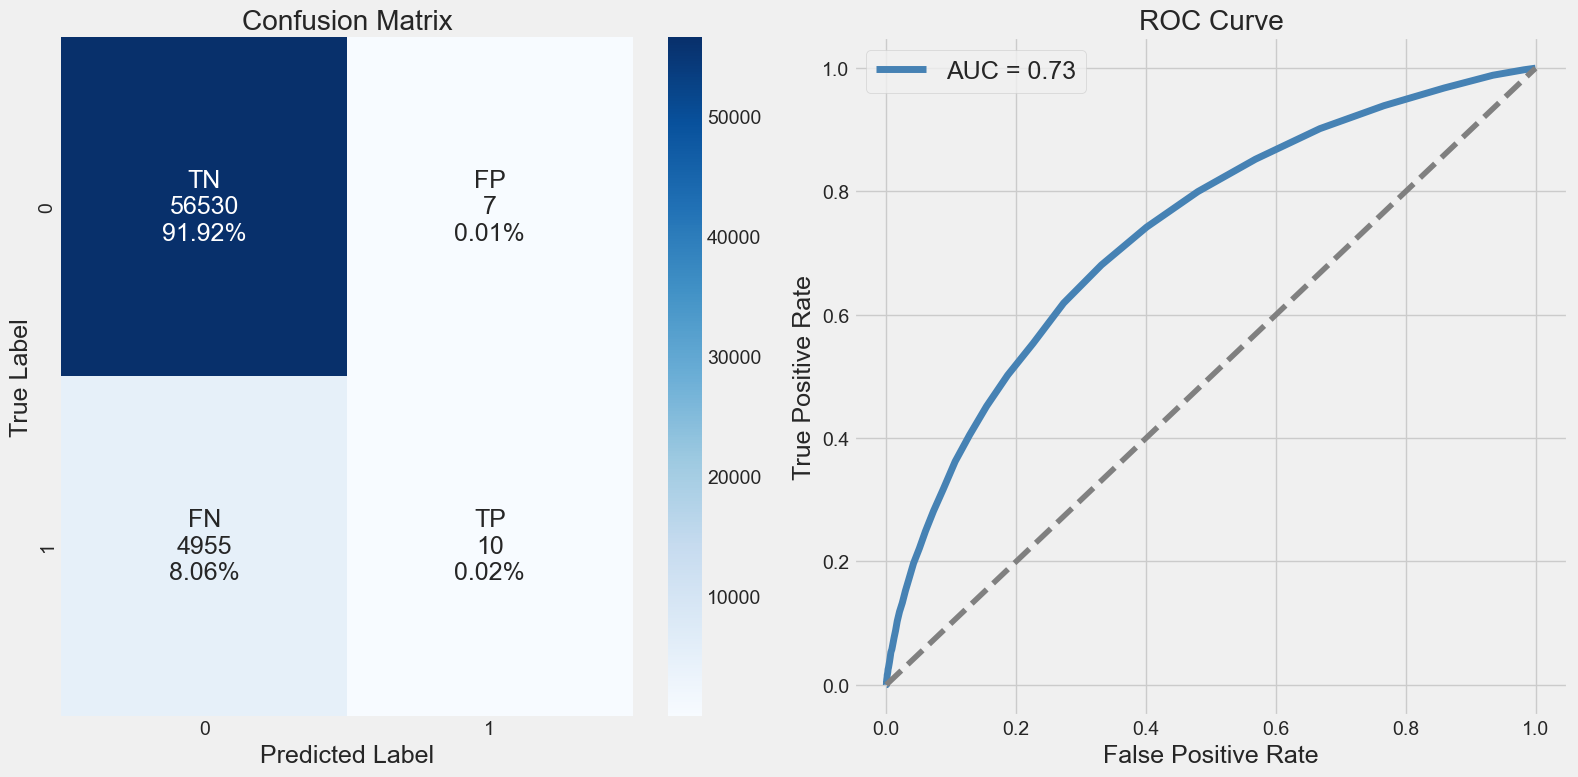

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  rf_balanced      0.92       0.59     0.0       0.0           0.73   

   custom_score  execution_time  
0          0.53         128.237

In [64]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_balanced, results_rf_balanced = mlfow_track("rf_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "rf_balanced", (16,8))

## Comparaison des résultas Random Forest

In [65]:
comp_rf = pd.concat([results_rf_origine, results_rf_unders, results_rf_overs, results_rf_balanced], axis=0)
comp_rf

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   rf_origine      0.92       0.78    0.00      0.00           0.72   
0    rf_unders      0.69       0.16    0.68      0.26           0.75   
0     rf_overs      0.92       0.35    0.03      0.05           0.72   
0  rf_balanced      0.92       0.59    0.00      0.00           0.73   

   custom_score  execution_time  
0          0.53         169.385  
0          0.69          20.042  
0          0.54         313.590  
0          0.53         128.237

# Lightgbm

# Data origine

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.55      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.74      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502



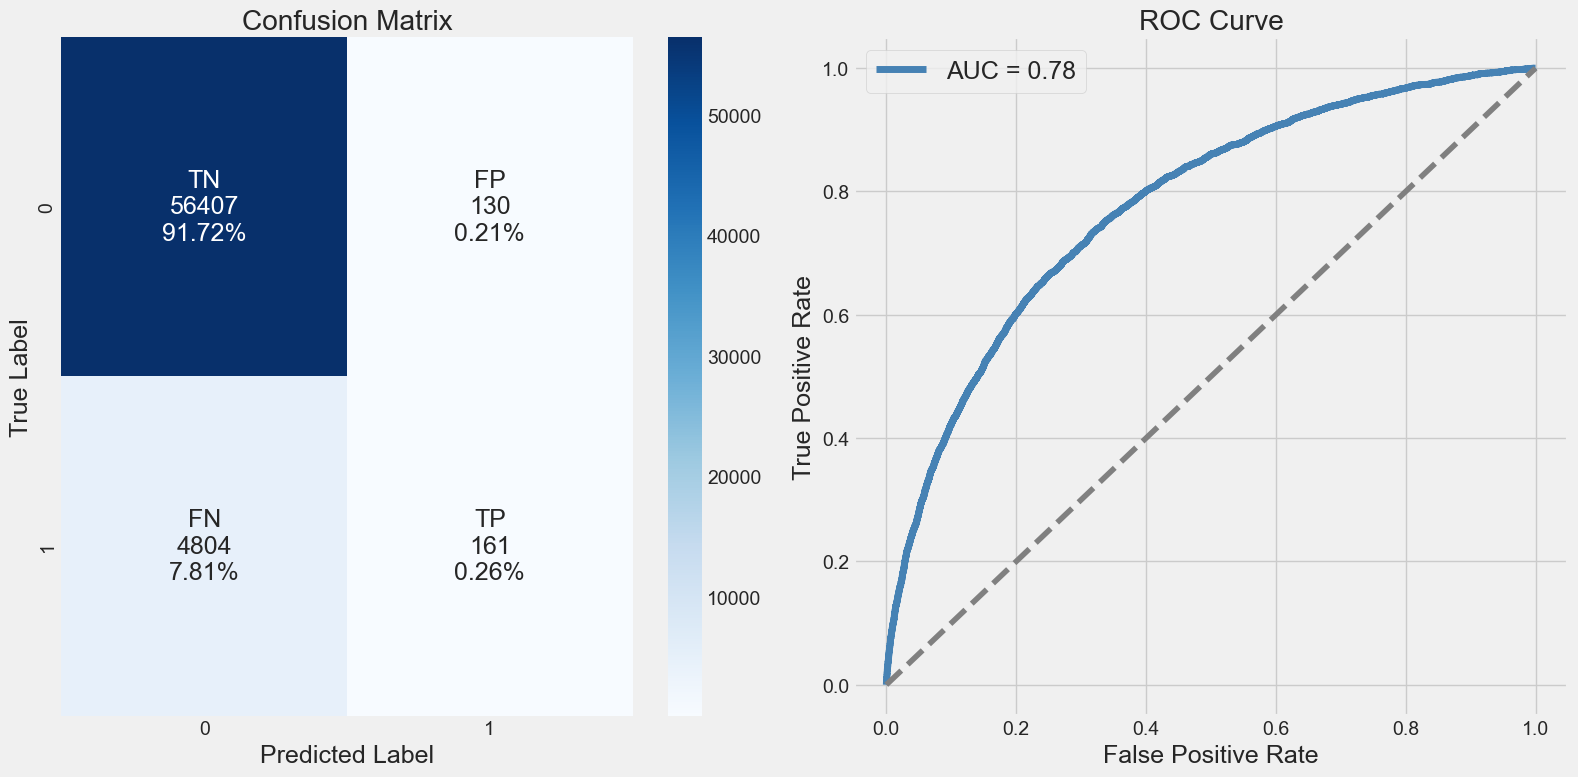

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_origine      0.92       0.55    0.03      0.06           0.78   

   custom_score  execution_time  
0          0.55          14.862

In [66]:
model = LGBMClassifier(random_state=42)
lgbm_origine, results_lgbm_origine = mlfow_track("lgbm_origine", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_origine", (16,8))

# Undersampled

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.70      0.28      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502



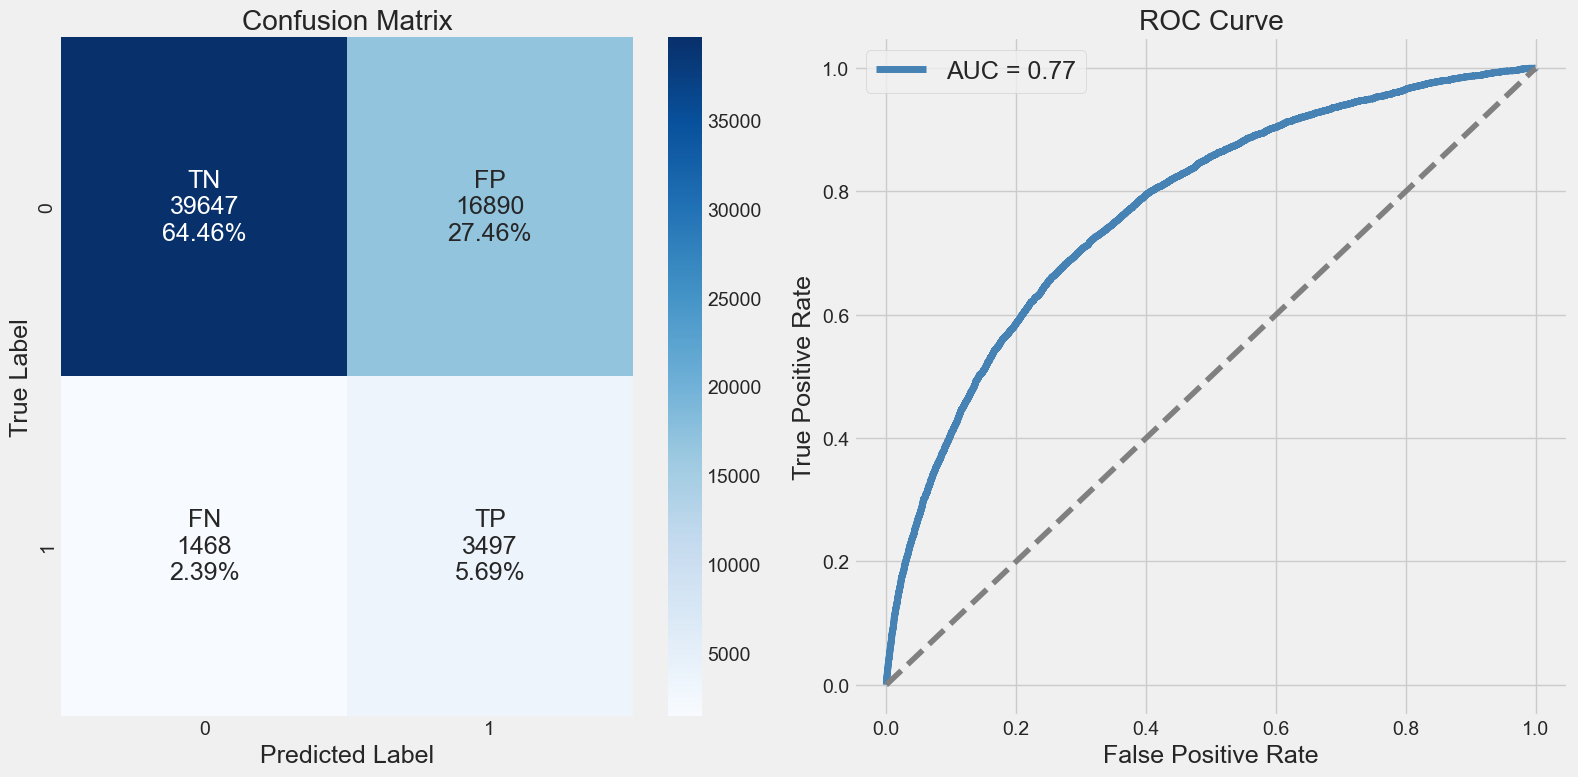

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_unders       0.7       0.17     0.7      0.28           0.77   

   custom_score  execution_time  
0           0.7           5.743

In [67]:
model = LGBMClassifier(random_state=42)
lgbm_unders, results_lgbm_unders = mlfow_track("lgbm_unders", model,
                             X_unders, y_unders, X_test_scaled, y_test, "lgbm_unders", (16,8))

## Oversampled

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.52      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



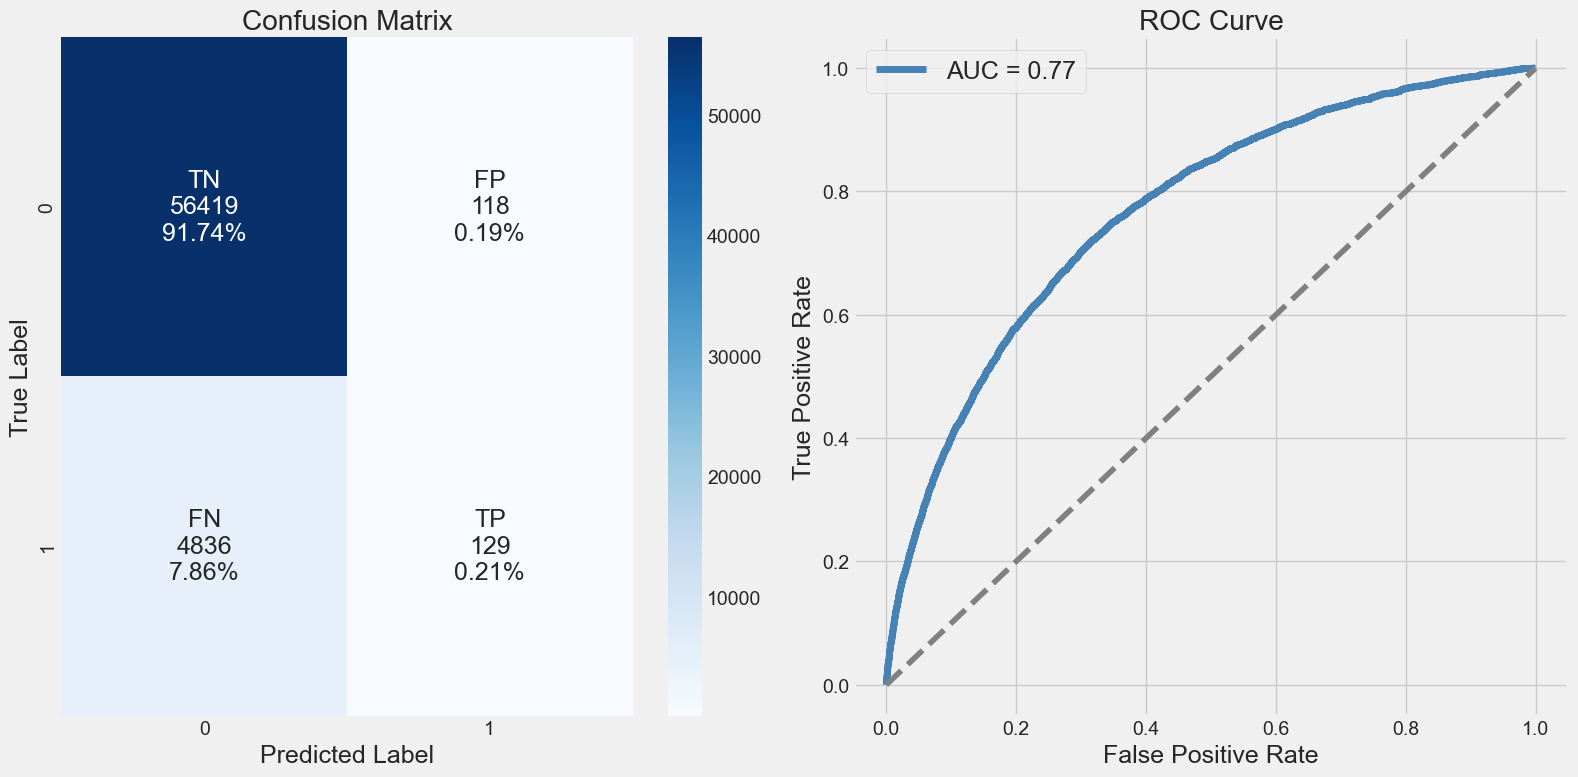

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_overs      0.92       0.52    0.03      0.05           0.77   

   custom_score  execution_time  
0          0.54          26.661

In [68]:
model = LGBMClassifier(random_state=42)
lgbm_overs, results_lgbm_overs = mlfow_track("lgbm_overs", model,
                             X_overs, y_overs, X_test_scaled, y_test, "lgbm_overs", (16,8))

# Class weigth balanced

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.83     56537
         1.0       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502



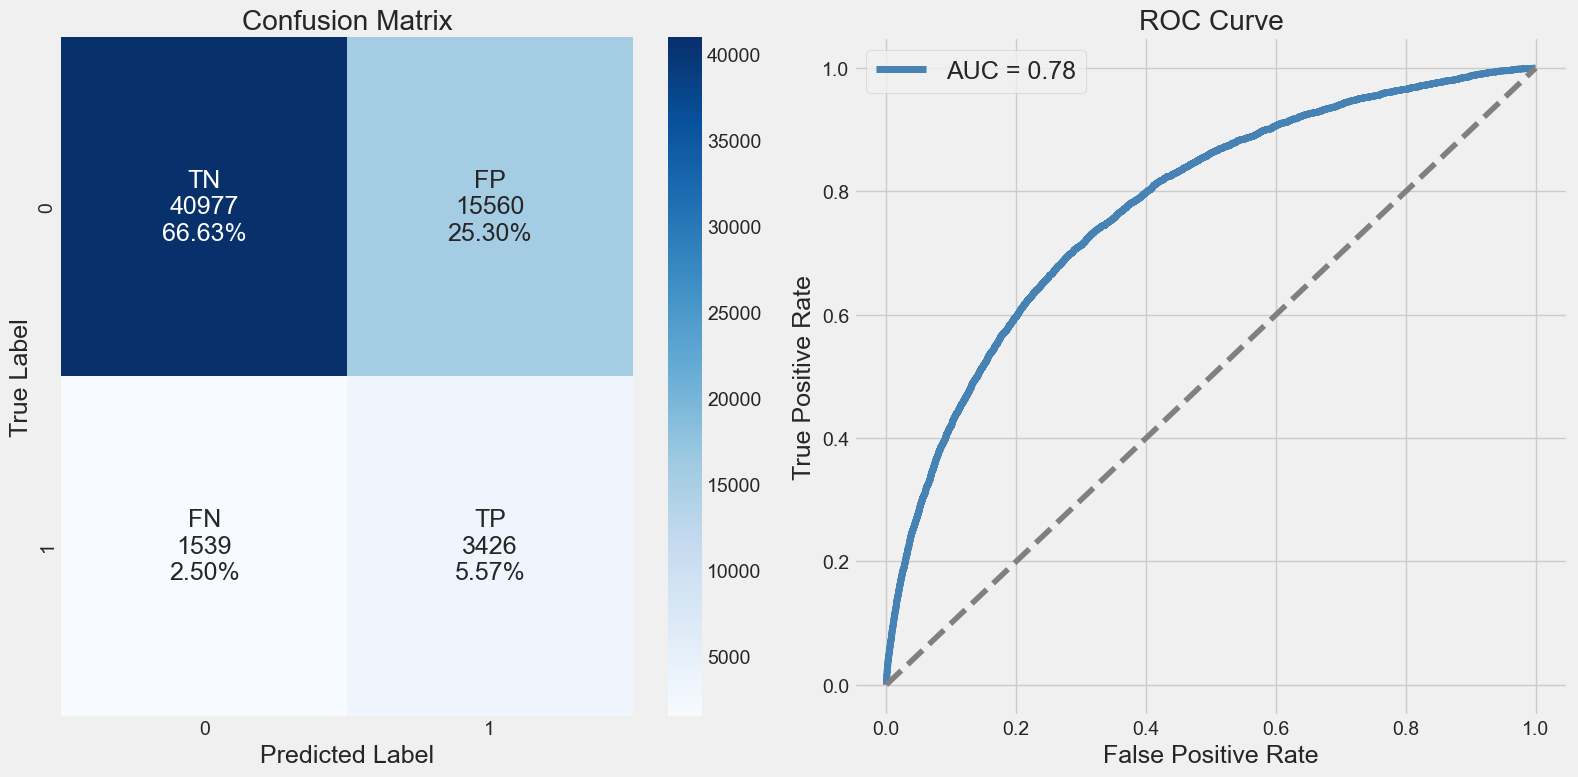

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.71          14.432

In [69]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_balanced, results_lgbm_balanced = mlfow_track("lgbm_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_balanced", (16,8))

## Comparaison des résultas LGBM

In [70]:
comp_lgbm = pd.concat([results_lgbm_origine, results_lgbm_unders, results_lgbm_overs, results_lgbm_balanced], axis=0)
comp_lgbm

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0   lgbm_origine      0.92       0.55    0.03      0.06           0.78   
0    lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0     lgbm_overs      0.92       0.52    0.03      0.05           0.77   
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.55          14.862  
0          0.70           5.743  
0          0.54          26.661  
0          0.71          14.432

# <a name="C13"> 3.4 Comparaison des résultats </a>
<a href="#top">sommaire</a>

# Comparaison Total avant feature selection

In [71]:
comp_total_before_imp = pd.concat([comp_dummy, comp_lr, comp_rf, comp_lgbm], axis=0)
comp_total_before_imp = comp_total_before_imp.sort_values("custom_score", ascending=False)
comp_total_before_imp

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   
0    lr_balanced      0.70       0.17    0.69      0.27           0.76   
0    lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0      lr_unders      0.69       0.17    0.69      0.27           0.76   
0      rf_unders      0.69       0.16    0.68      0.26           0.75   
0       lr_overs      0.71       0.17    0.65      0.26           0.75   
0   lgbm_origine      0.92       0.55    0.03      0.06           0.78   
0     lr_origine      0.92       0.50    0.02      0.04           0.76   
0       rf_overs      0.92       0.35    0.03      0.05           0.72   
0     lgbm_overs      0.92       0.52    0.03      0.05           0.77   
0  dummy_origine      0.92       0.00    0.00      0.00           0.50   
0   dummy_unders      0.92       0.00    0.00      0.00           0.50   
0    dummy_overs      0.92       0.00    0.00      0.00           0.50   
0     rf_origine      0.92       0.78    0.00      0.00           0.72   
0    rf_balanced      0.92       0.59    0.00      0.00           0.73   

   custom_score  execution_time  
0          0.71          14.432  
0          0.70          16.736  
0          0.70           5.743  
0          0.69           4.133  
0          0.69          20.042  
0          0.68          31.227  
0          0.55          14.862  
0          0.54          17.569  
0          0.54         313.590  
0          0.54          26.661  
0          0.53           8.687  
0          0.53           2.529  
0          0.53          16.852  
0          0.53         169.385  
0          0.53         128.237

On a choisi le modèle LightGBM avecla méthode d'utilisation de l'argument class_weight="balanced", qui a conduit à de meilleures performances.

# <a name="C14"> 4.1 Sélection de 10 features les plus importants </a>
<a href="#top">sommaire</a>

In [72]:
import shap
shap.initjs()

## Feature Importance pour lgbm balanced

In [73]:
# Affichage des features importance
def show_feature_importance(model,  data, name):
    
    feat_imp = model.feature_importances_
    df_feat_imp = pd.DataFrame(feat_imp, columns = ["Feature Importance"])
    df_feat_imp["Feature Name"] = data.columns
    df_feat_imp = df_feat_imp.sort_values(by="Feature Importance", ascending=False)
    display(df_feat_imp.head(10))   
    # Affichage Features importance
    plt.barh(df_feat_imp.head(10)["Feature Name"], df_feat_imp.head(10)["Feature Importance"])
    plt.xlabel("Feature Importance")
    plt.title(f"Feature importance pour le modele {name} ")
    plt.show()
    return None

Feature Importance             Feature Name
183                 186             PAYMENT_RATE
23                  125             EXT_SOURCE_2
24                  108             EXT_SOURCE_3
8                    91               DAYS_BIRTH
257                  78    PREV_CNT_PAYMENT_MEAN
9                    62            DAYS_EMPLOYED
6                    56              AMT_ANNUITY
393                  52          INSTAL_DPD_MEAN
11                   52          DAYS_ID_PUBLISH
380                  51  POS_MONTHS_BALANCE_SIZE

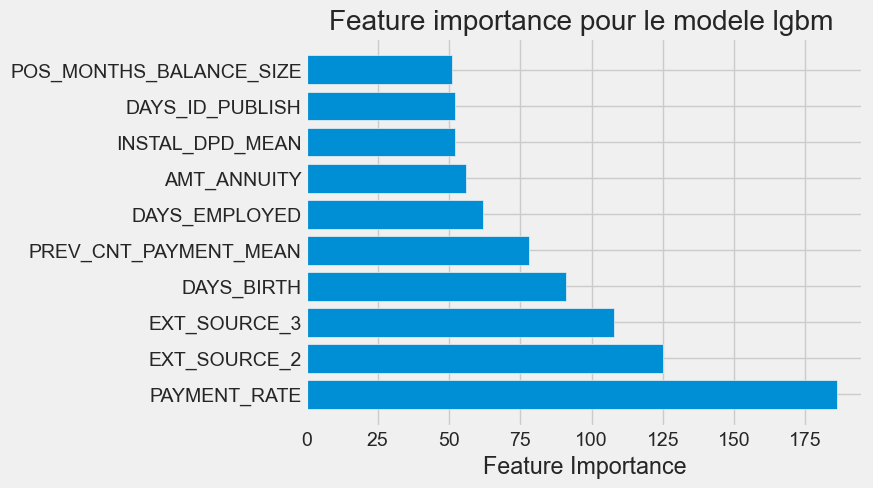

In [74]:
model = lgbm_balanced
show_feature_importance(model,  X_test_scaled, "lgbm")

## Summary Plot

Pour l'analyse globale de l'importance des features, nous utilisons 'summary_plot' pour identifier les features les plus importantes et comment chaque variable influence les prédictions.
Ci-dessous, nous avons généré un graphique summary plot avec un type de graphique de type barre basé sur les valeurs de forme générées à partir des données de test à l'aide de l'explainer. Le barplot montre l'impact moyen de chaque feature sur la prédiction finale. Cela met également en évidence l'importance des features basée sur les valeurs de forme.
Le summary plot peut gérer des valeurs de forme multiclasse. Ci-dessous, nous avons généré un graphique récapitulatif des données de test, et il est configuré par défaut pour un graphique à barres pour les problèmes multiclasse. Nous pouvons ainsi voir combien chaque attribut contribue en moyenne pour chaque type de classe.

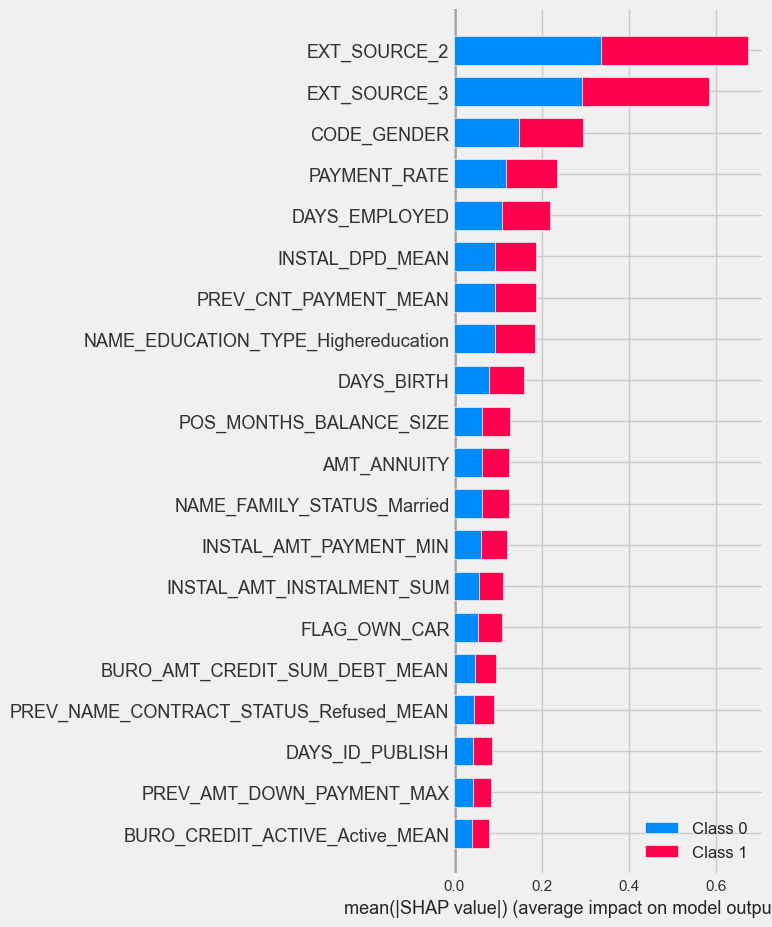

In [75]:
# Explain model predictions using shap library:
model = lgbm_balanced
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_scaled)

In [76]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_test_scaled.columns, sum(vals))),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(11)

col_name  feature_importance_vals
23                          EXT_SOURCE_2             20646.564231
24                          EXT_SOURCE_3             17903.116258
0                            CODE_GENDER              9082.964732
183                         PAYMENT_RATE              7212.477684
9                          DAYS_EMPLOYED              6703.165211
393                      INSTAL_DPD_MEAN              5767.690414
257                PREV_CNT_PAYMENT_MEAN              5735.043725
70   NAME_EDUCATION_TYPE_Highereducation              5672.766191
8                             DAYS_BIRTH              4877.065797
380              POS_MONTHS_BALANCE_SIZE              3940.345371
6                            AMT_ANNUITY              3860.142740

In [77]:
cols_importance = feature_importance.head(11).col_name
cols_importance.tolist()

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'POS_MONTHS_BALANCE_SIZE',
 'AMT_ANNUITY']

In [78]:
cols_importance = ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY']

In [79]:
# On a choisi ces 10 features les importants pour notre modèle

In [80]:
X_test_scaled.head(3)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343913         0.720924     -0.717489        -0.665211     -0.577535   
281768         0.720924     -0.717489        -0.665211     -0.577535   
215345         0.720924     -0.717489        -0.665211      0.809633   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                              
343913             -0.216620    0.387191     0.644464   
281768             -0.216620    1.199632     0.320462   
215345             -0.130181   -0.747354    -0.496384   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
343913                       -1.026464    0.991715      -0.282717   
281768                       -1.283180   -0.979982      -0.345732   
215345                       -0.084811   -0.959078      -0.802166   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
343913               1.068059        -0.543985       -2.135019   
281768               1.253195        -0.081154        0.468380   
215345               1.303170         1.066640        0.468380   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
343913            -0.498768          0.043658   -0.625028   -0.245444   
281768            -0.498768          0.043658    1.599928   -0.245444   
215345             2.004942          0.043658   -0.625028   -0.245444   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                  
343913                 -0.104342                 0.899170   
281768                  1.859443                -0.630415   
215345                 -0.104342                -1.242249   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
343913                       -0.123809                   -0.231497   
281768                       -0.123809                   -0.231497   
215345                       -0.123809                   -0.231497   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
SK_ID_CURR                                                                 
343913                   -0.291159               -0.547714      0.030433   
281768                   -0.291159               -0.547714      0.360033   
215345                   -0.291159                1.825771     -0.158852   

            EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                                     
343913          0.118993                 -0.587593                 -0.319781   
281768          0.883285                 -0.172953                 -0.319781   
215345          0.118993                 -0.587593                 -0.319781   

            DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
SK_ID_CURR                                                             
343913                    0.372526         -0.00727        -1.563268   
281768                    0.423330         -0.00727         0.639685   
215345                    0.824919         -0.00727         0.639685   

            FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
SK_ID_CURR                                                      
343913            -0.008789         -0.12472         3.208339   
281768            -0.008789         -0.12472        -0.311688   
215345            -0.008789         -0.12472        -0.311688   

            FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
SK_ID_CURR                                                      
343913            -0.013375        -0.298182        -0.062885   
2

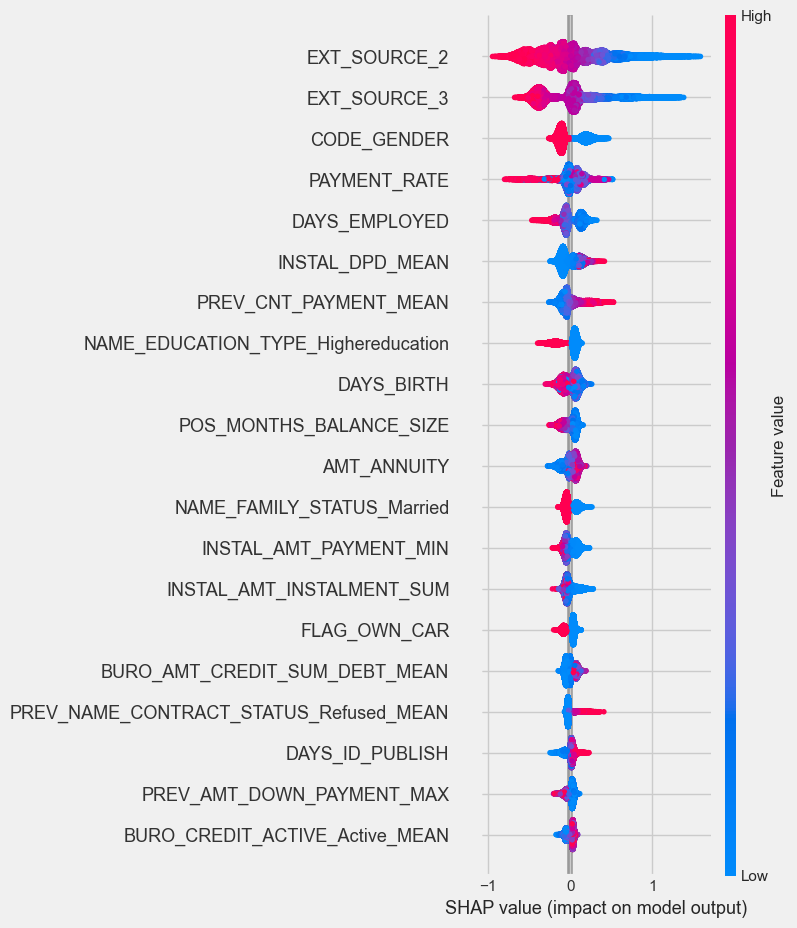

In [81]:
shap.summary_plot(shap_values[1], X_test_scaled, feature_names=X_test_scaled.columns)

100%|===================| 61378/61502 [03:09<00:00]        

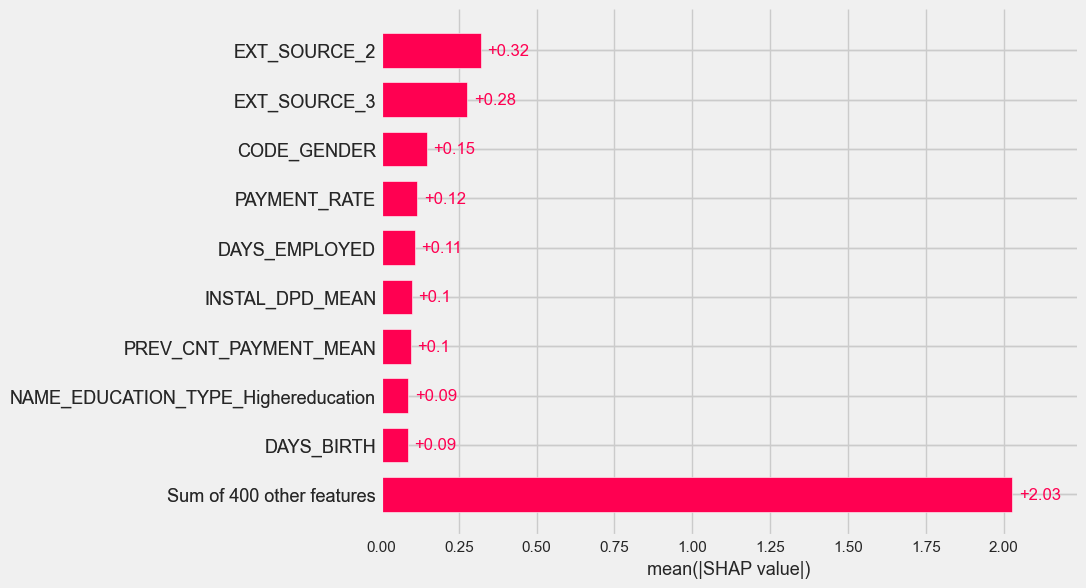

In [82]:
explainer = shap.Explainer(model, X_test_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)
shap.plots.bar(shap_values)

# Model avec feature selection avec 10 features les plus importants

In [83]:
cols_importance = ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY']

In [84]:
X_train_imp = X_train_scaled[cols_importance]
X_test_imp = X_test_scaled[cols_importance]
X_test_imp.shape

(61502, 10)

### LGBM Class weigth balanced avant feature sélection

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.83     56537
         1.0       0.18      0.69      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.71      0.56     61502
weighted avg       0.90      0.72      0.78     61502



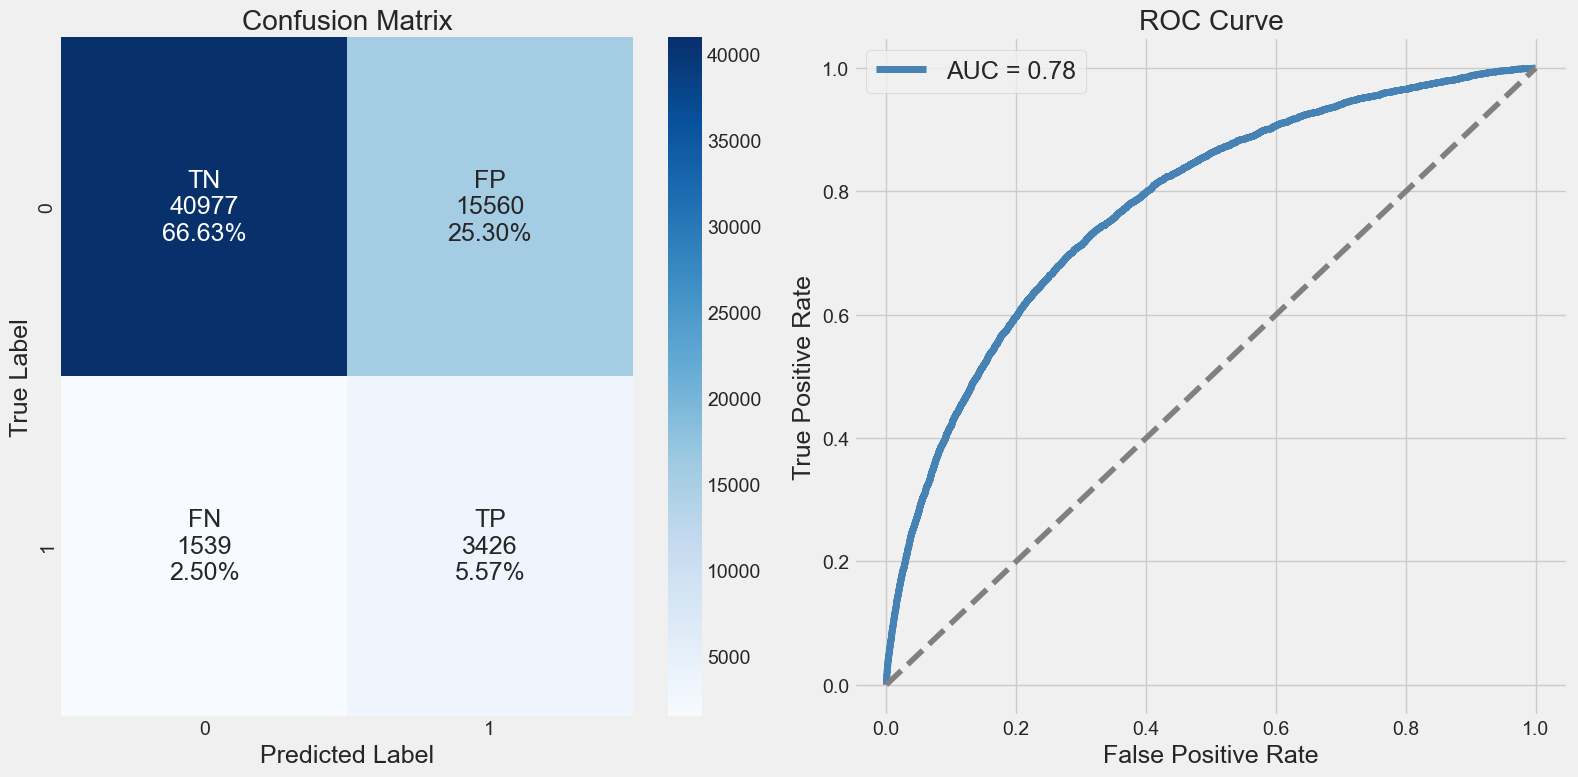

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.71          14.747

In [85]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_balanced, results_lgbm_balanced = mlfow_track("lgbm_balanced", model,
                             X_train_scaled, y_train, X_test_scaled, y_test, "lgbm_balanced", (16,8))

### LGBM Class weigth balanced après 10 features selectionnés

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



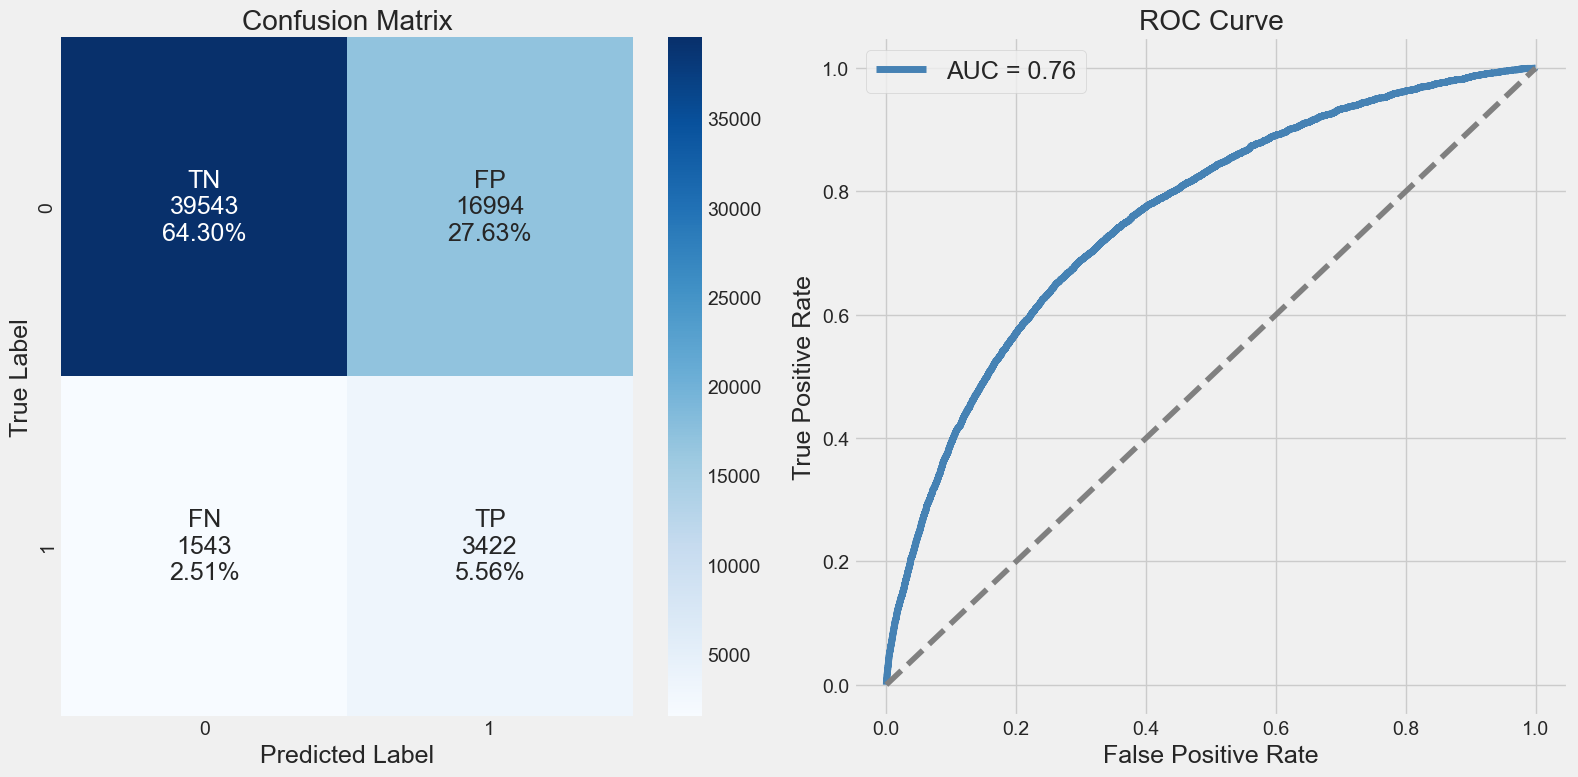

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_imp       0.7       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.69           1.798

In [86]:
model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_imp, results_lgbm_imp = mlfow_track("lgbm_imp", model,
                             X_train_imp, y_train, X_test_imp, y_test, "lgbm_imp", (16,8))

In [87]:
results_lgbm_balanced

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   

   custom_score  execution_time  
0          0.71          14.747

In [88]:
pd.concat([results_lgbm_balanced, results_lgbm_imp], axis=0)

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  lgbm_balanced      0.72       0.18    0.69      0.29           0.78   
0       lgbm_imp      0.70       0.17    0.69      0.27           0.76   

   custom_score  execution_time  
0          0.71          14.747  
0          0.69           1.798

Nous avons sélectionné les 10 features les plus importantes. Selon les résultats, le modèle (lgbm_imp) nous a donné un  custom score de 0.69 et une AUC ROC (roc_auc) de 0.76. Le modèle précédent (lgbm_balanced) avant la sélection de features avait un custom score de 0.71 et une AUC ROC de 0.78. Bien que nous ayons légèrement perdu en performance, nous avons gagné en termes de durée d'exécution et l’interprétabilité du modèle.

# <a name="C15"> 4.2 Sélection de meilleurs hyperparamètres (GridSearchCV) </a>
<a href="#top">sommaire</a>

# Gridsearch Model hyperparametre Tuning

In [89]:
params = {'n_estimators' : [100, 350, 500],
          
          'learning_rate': [0.05, 0.1, 0.2, 0.3]
         }

mlflow.lightgbm.autolog()
with mlflow.start_run(run_name='Grid_lgbm'):
    model = LGBMClassifier(class_weight="balanced", random_state=42)
    grid_lgbm = GridSearchCV(
        model,
        param_grid=params,
        cv=5,
        scoring="roc_auc",
        return_train_score=True)
    
    grid_lgbm.fit(X_train_imp, y_train)

2023/10/24 14:58:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


In [90]:
result_lgbm = pd.DataFrame(grid_lgbm.cv_results_)
result_lgbm.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.493662      0.052047         0.057460        0.002395   
1       1.076121      0.048613         0.108751        0.002718   
2       1.593752      0.161804         0.135255        0.002201   
3       0.455274      0.013761         0.047001        0.001396   
4       1.030038      0.110534         0.087055        0.002661   

  param_learning_rate param_n_estimators  \
0                0.05                100   
1                0.05                350   
2                0.05                500   
3                 0.1                100   
4                 0.1                350   

                                         params  split0_test_score  \
0  {'learning_rate': 0.05, 'n_estimators': 100}           0.754758   
1  {'learning_rate': 0.05, 'n_estimators': 350}           0.757280   
2  {'learning_rate': 0.05, 'n_estimators': 500}           0.756024   
3   {'learning_rate': 0.1, 'n_estimators': 100}           0.757422   
4   {'learning_rate': 0.1, 'n_estimators': 350}           0.752446   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.758039           0.749028           0.752422           0.747834   
1           0.759331           0.751537           0.754679           0.752285   
2           0.758695           0.750226           0.754184           0.750868   
3           0.758713           0.751556           0.754273           0.750864   
4           0.755157           0.748173           0.750254           0.747512   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.752416        0.003730                4            0.772319   
1         0.755022        0.002947                1            0.810083   
2         0.754000        0.003170                3            0.826096   
3         0.754566        0.003105                2            0.790800   
4         0.750709        0.002816                6            0.844552   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.772007            0.773146            0.772933   
1            0.808808            0.810326            0.810920   
2            0.824935            0.827095            0.827843   
3            0.789735            0.790905            0.790556   
4            0.844422            0.846289            0.845525   

   split4_train_score  mean_train_score  std_train_score  
0            0.773654          0.772812         0.000587  
1            0.810708          0.810169         0.000740  
2            0.826545          0.826503         0.000977  
3            0.790470          0.790493         0.000411  
4            0.845089          0.845176         0.000682

In [91]:
 # Obtenir les meilleurs hyperparamètres et le meilleur modèle
best_params = grid_lgbm.best_params_
best_model_lgbm = grid_lgbm.best_estimator_

In [92]:
best_params

{'learning_rate': 0.05, 'n_estimators': 350}

In [93]:
best_model_lgbm

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=350,
               random_state=42)

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.68      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



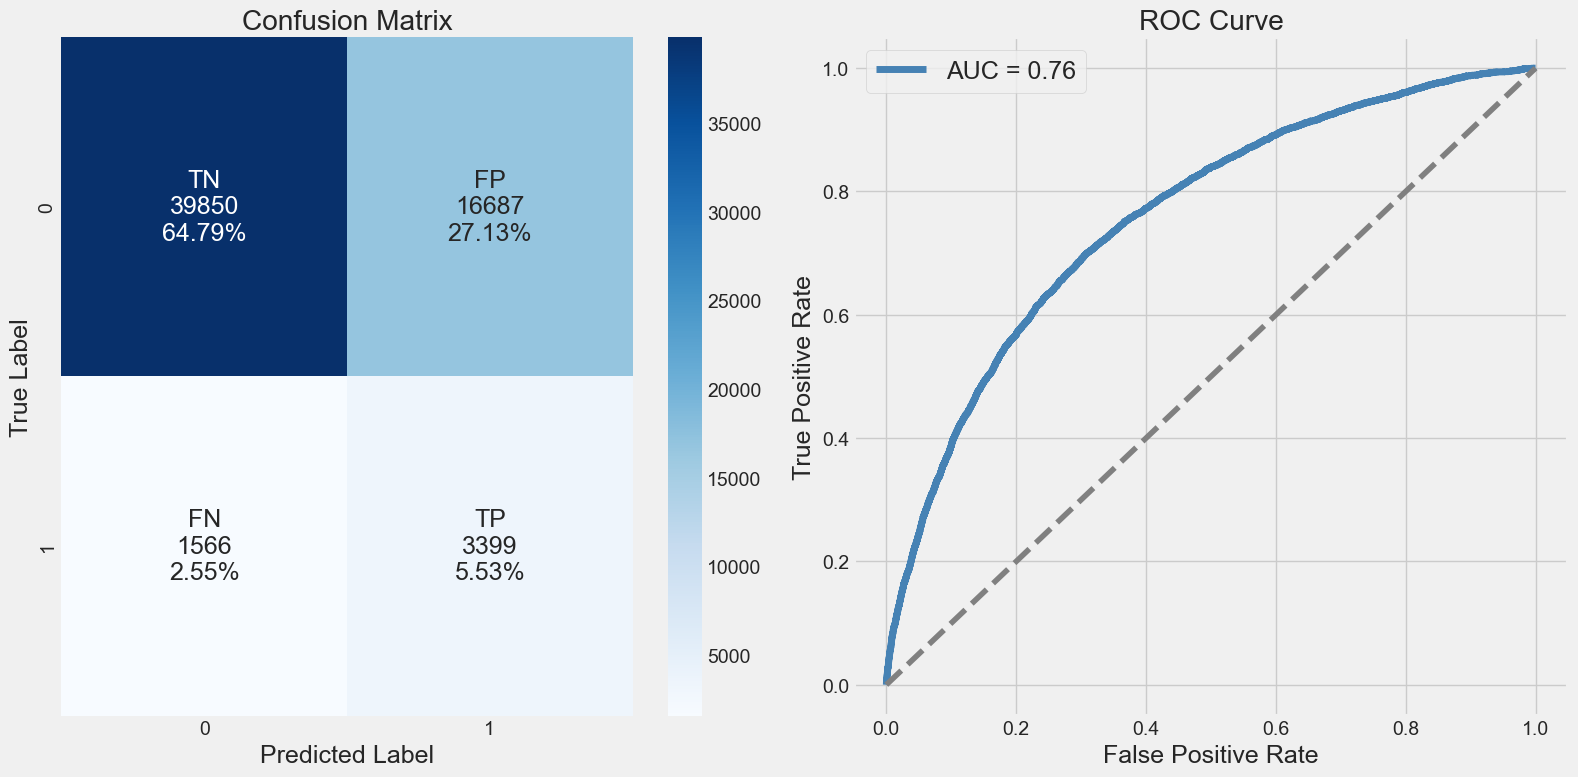

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  best_model_lgbm       0.7       0.17    0.68      0.27           0.76   

   custom_score  execution_time  
0           0.7           2.604

In [94]:
model = best_model_lgbm
best_model_lgbm, results_best_model_lgbm = mlfow_track("best_model_lgbm", model,
                             X_train_imp, y_train, X_test_imp, y_test, "best_model_lgbm", (16,8))

# <a name="C16"> 4.3 Interprétabilité globale et locale du modèle </a>
<a href="#top">sommaire</a>

## Interprétabilité globale du modèle

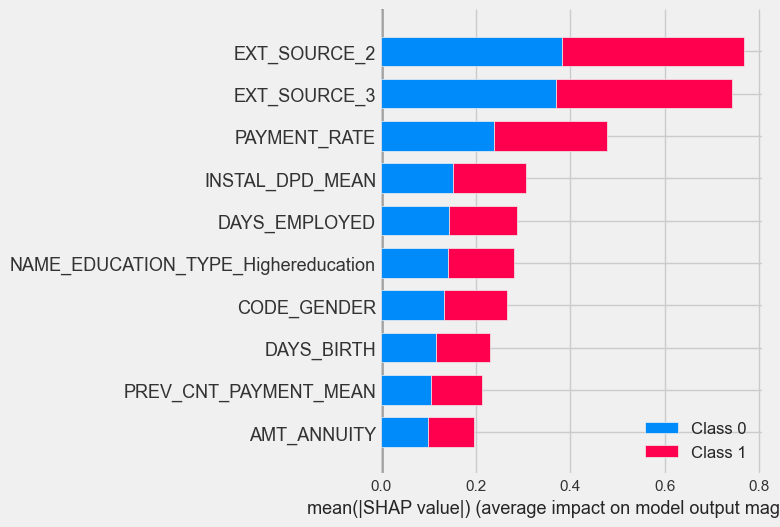

In [95]:
# Explain model predictions using shap library:
model = best_model_lgbm
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_imp)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_imp)

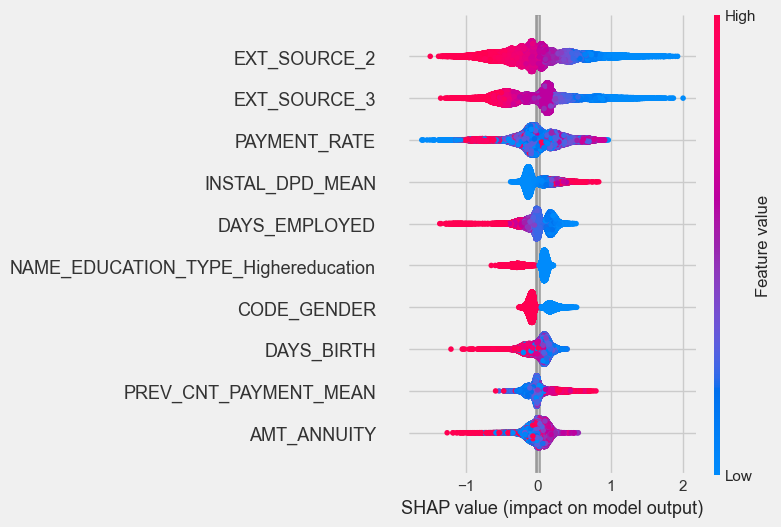

In [96]:
shap.summary_plot(shap_values[1], X_test_imp, feature_names=X_test_imp.columns)

Pour l'analyse globale de l'importance des features, nous utilisons 'summary_plot' pour identifier les features les plus importantes et comment chaque variable influence les prédictions. Sur l'axe vertical, un déplacement vers la gauche indique une réduction du risque de défaut de paiement, tandis qu'un déplacement vers la droite augmente ce risque. Les couleurs rouge et bleue indiquent respectivement des valeurs élevées et faibles. 

Par exemple, le genre masculin semble contribuer à un risque plus élevé de défaut, tandis qu'une faible valeur pour la EXT_SOURCE_2 et 3 est associée à un risque accru de défaut. De plus, de faibles valeurs pour la DAYS_EMPLOYED et DAYS_BIRTH augmentent le risque de défaut, tandis que des valeurs élevées pour INSTAL_DPD_MEAN augmentent également le risque de défaut.

**Features et Explications**
* EXT_SOURCE_2 et 3 ---> Score normalisé provenant d'une source de données externe
* PAYMENT_RATE ---> Taux de paiement
* INSTAL_DPD_MEAN ---> Nombre de jours de retard de paiement pour le crédit précédent (moyenne)
* DAYS_EMPLOYED ---> Durée du travail (ans)
* NAME_EDUCATION_TYPE_Highereducation ---> Niveau d'études le plus élevé (éducation supérieure)
* CODE_GENDER ---> Genre female - 1  male - 0
* PREV_CNT_PAYMENT_MEAN ---> Durée du crédit précédent (moyenne)
* DAYS_BIRTH ---> Age (ans)
* AMT_ANNUITY ---> Rente de prêt annuelle

## Interprétabilité locale du modèle

In [97]:
X_test_sample2 = X_test_imp.head(1)
X_test_sample2

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.030433      0.118993     0.720924     -0.241825   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913          -0.282717        -0.052077              -0.290348   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                  1.76257    0.991715     0.644464

### Shap pour X_test_sample2

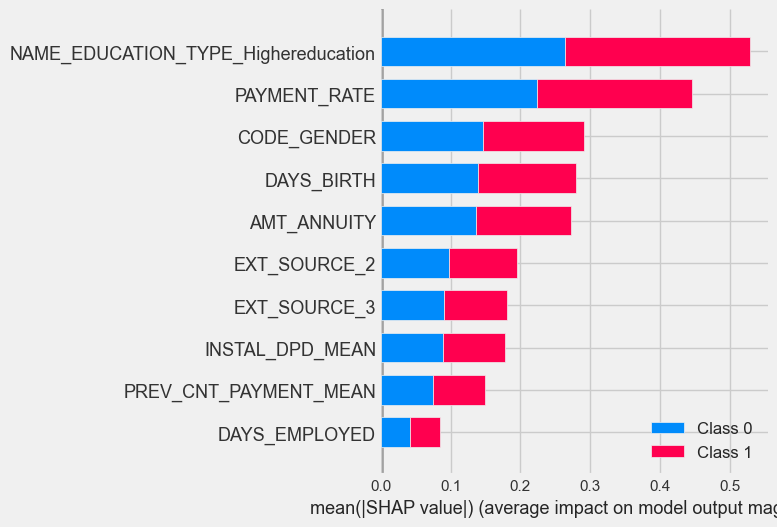

In [98]:
# Explain model predictions using shap library:
model = best_model_lgbm
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample2)
# Plot summary_plot
shap.summary_plot(shap_values, X_test_sample2)

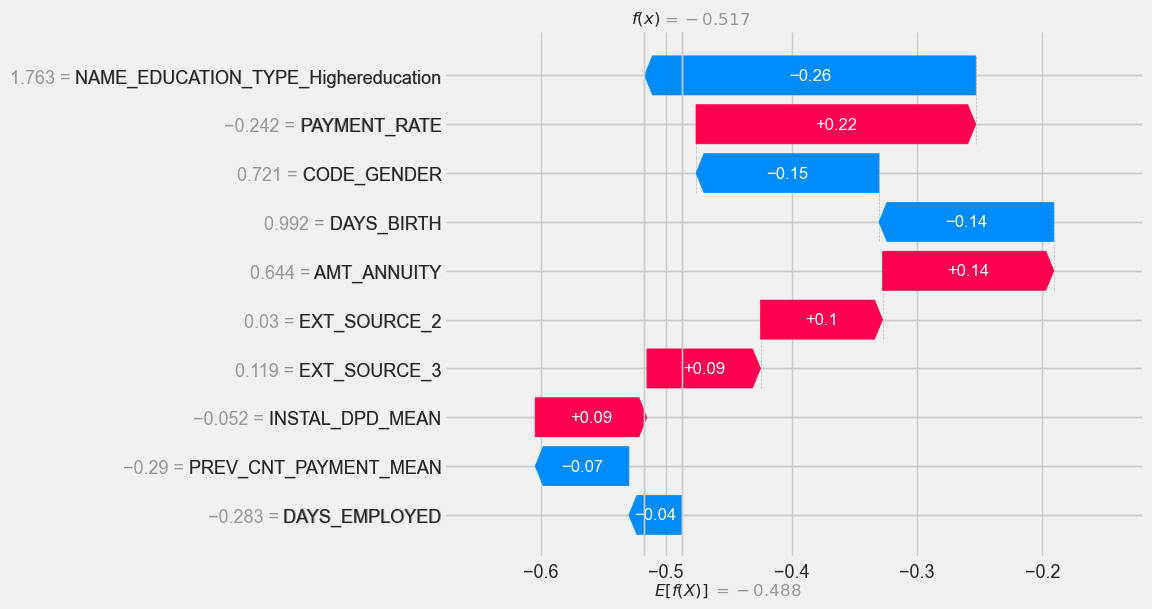

In [99]:
# Explain model predictions using shap library:
model = best_model_lgbm
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample2)
shap.waterfall_plot(explainer(X_test_sample2)[0][:,1])

Nous examinons maintenant l'impact spécifique des features sur la décision du modèle par rapport à une observation particulière. Le graphique présente l'impact de chaque feature pour l'individu sélectionné et comment ces features influencent la prédiction. Les features ayant un impact négatif sont en bleu, tandis que celles ayant un impact positif sont en rouge. 

Par exemple, pour le client ayant l'ID 343913, on constate que les features "NAME_EDUCATION_TYPE_Highereducation" et "DAYS_BIRTH" ont réduit le risque de défaut de paiement, tandis que les features "PAYMENT_RATE" et "AMT_ANNUITY" ont augmenté le risque de défaut de paiement pour ce client.


In [100]:
model = best_model_lgbm
prediction2 = model.predict_proba(X_test_sample2)[0][1].round(2)
prediction2

0.37

# <a name="C17"> 4.4 Seuil score métier </a>
<a href="#top">sommaire</a>

In [101]:
def threshold_optimum(model, X_test, y_test):

    #y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    scores = []
    for threshold in np.arange(0, 1.1, 0.01):
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        score = fonction_metier(y_test, y_pred)
        scores.append(score)


    score_max = max(scores)
    threshold_optimum = np.arange(0, 1.1, 0.01)[scores.index(score_max)]
    y_pred = np.where(y_pred_proba > threshold_optimum, 1, 0)
    
    print("Max custom score : ", score_max.round(2))
    print("Threshold optimum : ", threshold_optimum)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(np.arange(0, 1.1, 0.01), scores, label="model score")
    plt.axvline(x=threshold_optimum, color='r', dashes=(0.1, 2), 
                label="Threshold optimum: {}".format(threshold_optimum))
    plt.title("Custom score vs threshold", fontsize=10)
    plt.xlabel("Thresholds", fontsize=10)
    plt.ylabel("Custom score", fontsize=10)
    
    plt.legend()
    plt.show()
     

Max custom score :  0.7
Threshold optimum :  0.54


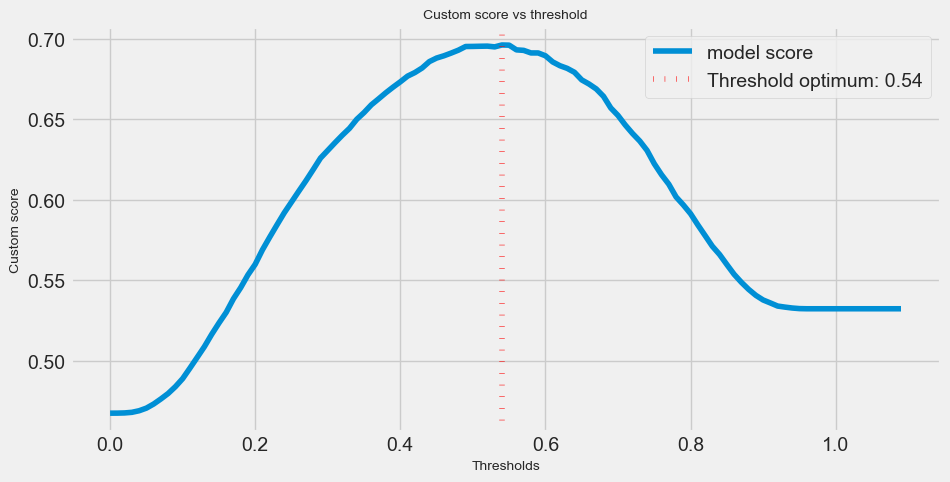

In [102]:
threshold_optimum(best_model_lgbm, X_test_imp, y_test)

Selon les résultats, notre modèle va prédire qu'un client est considéré comme non solvable à partir d'une probabilité de défaut de plus de 54%.

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
import time

def evaluation_score_threshold(model, X_train, y_train, X_test, y_test, model_name, figsize, custom_threshold=None):
    '''
    Calcule, affiche et enregistre différentes métriques.
    
    :param model: Le modèle d'apprentissage automatique à évaluer.
    :param X_train: Données d'entraînement.
    :param y_train: Étiquettes cibles pour les données d'entraînement.
    :param X_test: Données de test.
    :param y_test: Vraies étiquettes pour les données de test.
    :param figsize: Tuple spécifiant la taille de la figure pour la courbe ROC.
    :param model_name: Nom du modèle (pour le DataFrame de résultats).
    :param custom_threshold: Seuil personnalisé facultatif pour les prédictions binaires (la valeur par défaut est de 0,5).
    :return: Un DataFrame avec les métriques.
    '''
    start_time = time.time()
    model.fit(X_train, y_train)
    execution_time = time.time() - start_time
    execution_time = round(execution_time, 3)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    if custom_threshold is not None:
        # Use the custom threshold for binary predictions
        y_pred = np.where(y_pred_proba > custom_threshold, 1, 0)
    
    metier = fonction_metier(y_test, y_pred).round(2)
    accuracy = metrics.accuracy_score(y_test, y_pred).round(2)
    precision = metrics.precision_score(y_test, y_pred).round(2)
    recall = metrics.recall_score(y_test, y_pred).round(2)
    f1_score = metrics.f1_score(y_test, y_pred).round(2)
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba).round(2)

    # Display classification report
    print(classification_report(y_test, y_pred))

    # Display confusion matrix and ROC curve
    conf_matrix_roc_curve(y_test, y_pred, y_pred_proba, figsize)

    # Create a DataFrame with rounded metrics
    results = pd.DataFrame({'model': [model_name],
                            'accuracy': [accuracy],
                            'precision': [precision],
                            'recall': [recall],
                            'f1_score': [f1_score],
                            'roc_auc_score': [auc_score],
                            'custom_score': [metier],
                            'execution_time': [execution_time]})
      
    display(results)
    return results, accuracy, precision, recall, f1_score, auc_score, metier

In [107]:
def mlfow_track_threshold(exp_name, model, X_train, y_train, X_test, y_test, model_name, figsize,
                          custom_threshold):
    model = model
    signature = infer_signature(X_train, y_train)
    plt.style.use('fivethirtyeight')
    mlflow.set_experiment(exp_name)
    mlflow.sklearn.autolog()
    mlflow.lightgbm.autolog()
    with mlflow.start_run(run_name=exp_name):
        model.fit(X_train, y_train)
        results, accuracy, precision, recall, f1_score, auc_score,\
        metier = evaluation_score_threshold(model, X_train, y_train, X_test, y_test, model_name, figsize,
                                           custom_threshold=custom_threshold) 
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("custom_score", metier)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.log_metric("rocauc", auc_score)
    return model, results

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.84     56537
         1.0       0.18      0.63      0.28      4965

    accuracy                           0.74     61502
   macro avg       0.57      0.69      0.56     61502
weighted avg       0.90      0.74      0.80     61502



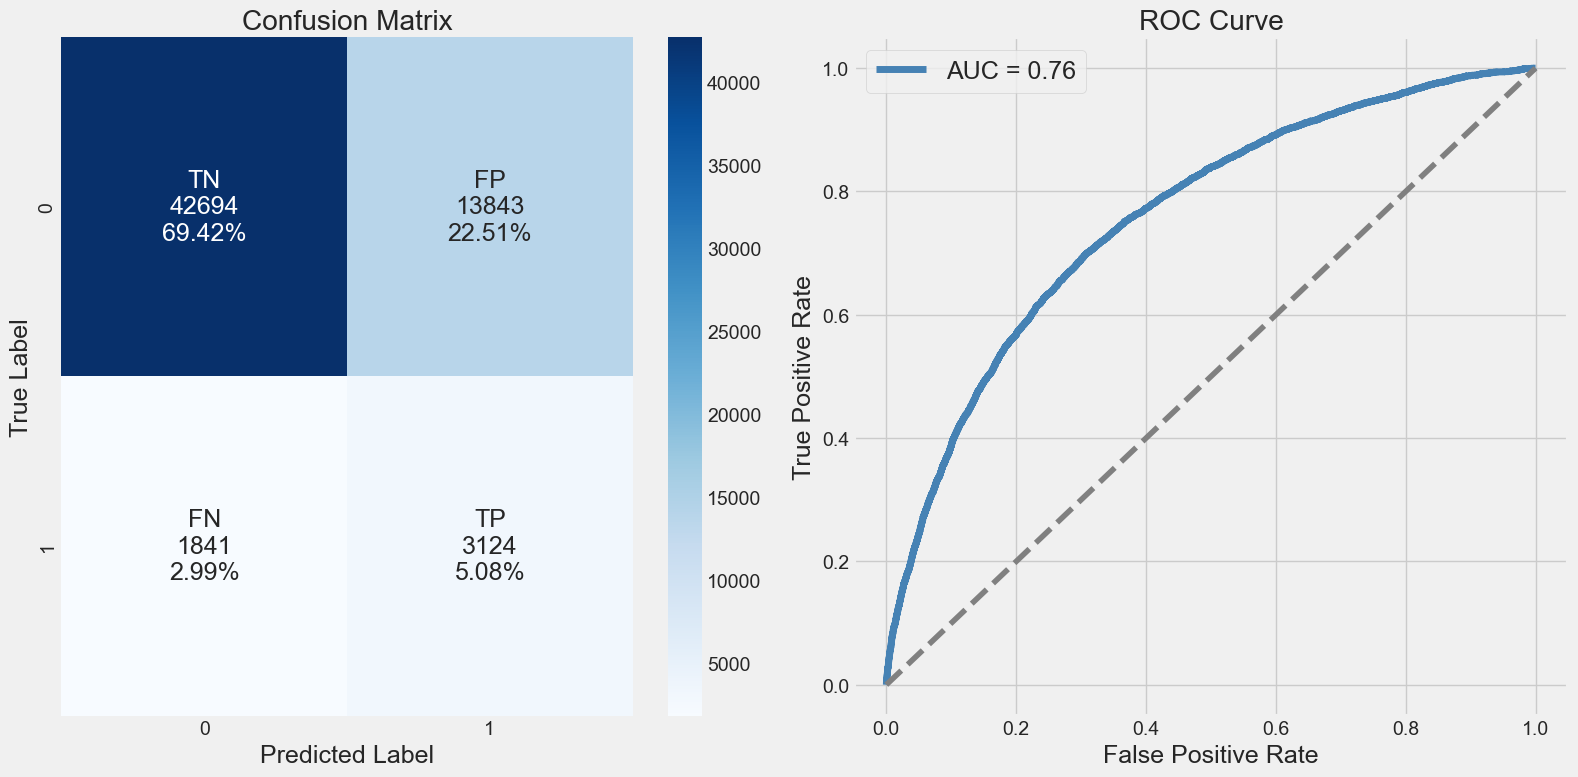

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  threshold_best_model      0.74       0.18    0.63      0.28           0.76   

   custom_score  execution_time  
0           0.7           2.769

In [108]:
best_model_lgbm, results_threshold_best_model = mlfow_track_threshold("threshold_best_model",
                                                                 best_model_lgbm, X_train_imp, y_train, X_test_imp,
                      y_test, "threshold_best_model", (16,8), 0.54)

In [109]:
results_best_model_lgbm

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  best_model_lgbm       0.7       0.17    0.68      0.27           0.76   

   custom_score  execution_time  
0           0.7           2.604

# <a name="C22"> 4.5 Comparaison Total après feature selection </a>
<a href="#top">sommaire</a>

In [110]:
comp_total_after_imp = pd.concat([results_threshold_best_model, results_best_model_lgbm,
                                  comp_total_before_imp], axis=0)
comp_total_after_imp

model  accuracy  precision  recall  f1_score  roc_auc_score  \
0  threshold_best_model      0.74       0.18    0.63      0.28           0.76   
0       best_model_lgbm      0.70       0.17    0.68      0.27           0.76   
0         lgbm_balanced      0.72       0.18    0.69      0.29           0.78   
0           lr_balanced      0.70       0.17    0.69      0.27           0.76   
0           lgbm_unders      0.70       0.17    0.70      0.28           0.77   
0             lr_unders      0.69       0.17    0.69      0.27           0.76   
0             rf_unders      0.69       0.16    0.68      0.26           0.75   
0              lr_overs      0.71       0.17    0.65      0.26           0.75   
0          lgbm_origine      0.92       0.55    0.03      0.06           0.78   
0            lr_origine      0.92       0.50    0.02      0.04           0.76   
0              rf_overs      0.92       0.35    0.03      0.05           0.72   
0            lgbm_overs      0.92       0.52    0.03      0.05           0.77   
0         dummy_origine      0.92       0.00    0.00      0.00           0.50   
0          dummy_unders      0.92       0.00    0.00      0.00           0.50   
0           dummy_overs      0.92       0.00    0.00      0.00           0.50   
0            rf_origine      0.92       0.78    0.00      0.00           0.72   
0           rf_balanced      0.92       0.59    0.00      0.00           0.73   

   custom_score  execution_time  
0          0.70           2.769  
0          0.70           2.604  
0          0.71          14.432  
0          0.70          16.736  
0          0.70           5.743  
0          0.69           4.133  
0          0.69          20.042  
0          0.68          31.227  
0          0.55          14.862  
0          0.54          17.569  
0          0.54         313.590  
0          0.54          26.661  
0          0.53           8.687  
0          0.53           2.529  
0          0.53          16.852  
0          0.53         169.385  
0          0.53         128.237

Nous avons testé les algorithmes, le Dummy Classifier, la Régression Logistique, le Random Forest et le Light GBM, en utilisant à la fois les ensembles de données d'origine déséquilibrés et les trois techniques d'équilibrage mentionnées précédemment. Les meilleurs résultats ont été obtenus avec le modèle Light GBM (lgbm_balanced) en utilisant la pondération de classe équilibrée (class_weight balanced).

Ensuite, nous avons sélectionné les 10 features les plus importantes et effectué une GridSearchCV. Selon les résultats, le modèle (best_model_lgbm) nous a donné un  custom score de 0.70 et une AUC ROC (roc_auc) de 0.76. Le modèle précédent (lgbm_balanced) avant la sélection de features avait un custom score de 0.71 et une AUC ROC de 0.78. Bien que nous ayons légèrement perdu en performance, nous avons gagné en termes de durée d'exécution et l’interprétabilité du modèle.

Enfin, nous avons ajusté le seuil de décision du modèle (threshold_best_model) en le passant de 0.50 par défaut à 0.54, ce qui a eu très peu d'impact sur les résultats

# <a name="C18"> 5.1 Analyse de data drift </a>
<a href="#top">sommaire</a>

In [111]:
from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric

In [112]:
#drift_train = pd.read_csv(path + 'data_p7/application_train.csv')
#drift_test = pd.read_csv(path + 'data_p7/application_test.csv')

In [113]:
#drift_train.drop("TARGET", axis=1, inplace=True)

In [114]:
#data_drift_report = Report(metrics=[DatasetDriftMetric(), DataDriftTable()])
#data_drift_report.run(reference_data=drift_train, current_data=drift_test)

In [115]:
#data_drift_report.save_html('data_drift_report.html')  

Le "data drift" est la modification de la qualité et de la distribution des données au fil du temps, ce qui peut affecter les performances d'un modèle de machine learning. Il nécessite une surveillance continue et des ajustements pour maintenir la précision du modèle.

On a testé la librairie evidently pour détecter dans le futur du Data Drift en production. Pour cela on a pris comme hypothèse que le dataset “application train” représente les datas pour la modélisation et le dataset “application test” représente les datas de nouveaux clients une fois le modèle en production. 

On constate une légère data drift  pour 9 colonnes de dataset. 

# <a name="C19"> 6.1 Préparation des datasets et pipelines pour api et dashboard </a>
<a href="#top">sommaire</a>

## Data pour comparaison voisins dashboard

Pour trouver les voisins les plus proches de notre client sélectionné et les comparer avec les voisins, nous avons besoin d'un ensemble d'entraînement (train set) comprenant les 10 features les plus importants. 

Ce dataset est le dataset initial, c'est-à-dire qu'il n'a pas encore été prétraité. Nous allons donc effectuer le prétraitement à l'aide de notre pipeline que nous avons créé, et pour générer les graphiques, nous avons besoin des données non standardisées. Pour ce faire, nous utiliserons l'imputer que nous avons enregistré, dans les codes du dashbord Streamlit. 

Nous avons également réduit le jeu de données à 1000 exemples en raison de limitations de ressources du côté d'Héroku, Github et Streamlit.

In [116]:
cols_prep = ['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'PAYMENT_RATE',
 'DAYS_EMPLOYED',
 'INSTAL_DPD_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'DAYS_BIRTH',
 'AMT_ANNUITY', 'TARGET']

In [117]:
df_X_train_null = X_train_null.copy()
df_X_train_null["TARGET"] = y_train

In [118]:
data_knn = df_X_train_null[cols_prep ]
data_knn_sample = data_knn.sample(1000, random_state=42)
#data_knn_sample.to_csv("data_knn_sample.csv")

## Data qu'on va envoyer à l'Api pour tester les prédictions des clients 

Pour calculer la probablité faillite et aussi les shap values côté l'API, nous avons besoin d'un ensemble test set comprenant les 10 features les plus importants. 

Ce dataset est le dataset initial, c'est-à-dire qu'il n'a pas encore été prétraité. Nous allons donc effectuer le prétraitement à l'aide de notre pipeline que nous avons crée côté l'API. 

Nous avons également réduit le jeu de données à 1000 exemples en raison de limitations de ressources du côté d'Héroku, Github et Streamlit.

In [119]:
X_train2 = X_train_null[cols_importance]
X_train2.shape

(246005, 10)

In [120]:
X_test2 = X_test_null[cols_importance]
X_test2.shape

(61502, 10)

In [121]:
data_for_test = X_test2.reset_index()
data_for_test.SK_ID_CURR = data_for_test.SK_ID_CURR.astype(int)
data_test_sample = data_for_test[0:1000]
data_test_sample

SK_ID_CURR  EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
0        343913      0.520273           NaN            1      0.048278   
1        281768      0.583140      0.670652            1      0.029356   
2        215345      0.484170           NaN            1      0.066826   
3        421739      0.129826      0.771362            1      0.097598   
4        408896      0.111119      0.396220            1      0.048872   
..          ...           ...           ...          ...           ...   
995      121982      0.435316      0.484851            1      0.067646   
996      310741      0.577233           NaN            1      0.044174   
997      144594      0.128623      0.754406            0      0.065554   
998      391861      0.604722      0.646330            1      0.034760   
999      121173      0.655214      0.475850            0      0.048265   

     DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
0              NaN         0.533333              12.000000   
1             4.15         0.000000              24.000000   
2             1.47         1.733333              12.000000   
3              NaN         0.000000               4.666667   
4              NaN         0.000000              24.200000   
..             ...              ...                    ...   
995           2.81         3.914286              24.000000   
996          15.14         0.019231              18.666667   
997           2.47         0.636364              11.000000   
998          12.68         0.434783               8.000000   
999           1.15         0.208333              16.000000   

     NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
0                                      1       55.80      36459.0  
1                                      0       32.22      31770.0  
2                                      0       32.47      19948.5  
3                                      0       64.24      68944.5  
4                                      0       62.99       8167.5  
..                                   ...         ...          ...  
995                                    0       27.84      18234.0  
996                                    0       41.05      45040.5  
997                                    0       27.38      18643.5  
998                                    0       32.47      62568.0  
999                                    0       45.55      40320.0  

[1000 rows x 11 columns]

In [122]:
#data_test_sample.to_csv("data_test_sample.csv", index=False)

## Data pour info clients pour dashboard streamlit

Comme nous avons réduit notre jeu de données à 10 features, pour obtenir d'autres informations à afficher dans le tableau de bord, nous allons utiliser le fichier d'entraînement "application train" avec 1000 exemples.

In [123]:
app_train = pd.read_csv("data_p7/application_train.csv")
app_train.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0           0.00         0.0690         0.0833         0.1250        0.0369   
1           0.08         0.0345         0.2917         0.3333        0.0130   

   LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0                0.0202          0.0190                   0.0000   
1                0.0773          0.0549                   0.0039   

   NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  \
0             0.0000           0.0252             0.0383   
1             0.0098           0.0924             0.0538   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  \
0                        0.9722            0.6341           0.0144   
1                        0.9851            0.8040           0.0497   

   ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  \
0          0.0000          0.0690          0.0833          0.1250   
1          0.0806          0.0345          0.2917          0.3333   

   LANDAREA_MODE  

In [124]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

In [125]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [126]:
app_train.DAYS_BIRTH = (app_train.DAYS_BIRTH / -365).round(2)
app_train.DAYS_EMPLOYED = (app_train.DAYS_EMPLOYED / -365).round(2)

In [127]:
# Assuming df1 and df2 are your dataframes with ID columns
matching_ids = data_test_sample['SK_ID_CURR'].tolist()
filtered_data_sample = app_train[app_train['SK_ID_CURR'].isin(matching_ids)]
filtered_data_sample.shape

(1000, 122)

In [128]:
filtered_data_sample.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
276      100319       0         Cash loans           F            N   
321      100369       0         Cash loans           F            N   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
276               Y             1          135000.0    781920.0      32868.0   
321               Y             0          157500.0    528633.0      22527.0   

     AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
276         675000.0   Unaccompanied  Commercial associate   
321         472500.0   Unaccompanied  Commercial associate   

               NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
276               Higher education            Married  House / apartment   
321  Secondary / secondary special            Married  House / apartment   

     REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
276                    0.022625       31.87           2.14            -7868.0   
321                    0.010500       52.94           1.56              -67.0   

     DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  \
276            -2992          NaN           1               1   
321            -2779          NaN           1               1   

     FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
276                1                 1           1           0   
321                0                 1           0           0   

    OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
276             NaN              3.0                     2   
321        Laborers              2.0                     3   

     REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
276                            2                   THURSDAY   
321                            3                    TUESDAY   

     HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
276                        8                           0   
321                       16                           0   

     REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
276                           0                            0   
321                           0                            0   

     REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
276                       0                       0                        0   
321                       0                       0                        0   

          ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
276  Business Entity Type 3      0.653368      0.565290      0.495666   
321           Self-employed      0.719260      0.271443      0.771362   

     APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
276          0.0835            0.1024                       0.9891   
321          0.4082            0.1640                       0.9995   

     YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
276           0.8504          0.0481           0.00         0.1379   
321           0.9932          0.0683           0.32         0.1379   

     FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
276         0.1667         0.2083        0.0987                0.0672   
321         0.6250         0.6667        0.1931                0.3291   

     LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
276          0.1035                   0.0039             0.0010   
321          0.2011                   0.0174             0.1108   

     APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
276           0.0851             0.1063                        0.9891   
321           0.2437             0.0867                        0.9995   

     YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  \
276            0.8563           0.0486          0.0000          0.1379   
321            0.9935           0.0582          0.1611          0.0690 

In [129]:
#filtered_data_sample.to_csv("filtered_data_sample.csv", index=False)

# On va entrainer imputer et scaler avec 10 features

## Imputer

In [130]:
from sklearn.impute import SimpleImputer
imputer2 = SimpleImputer(missing_values=np.nan, strategy="median")
X_train3 = imputer2.fit_transform(X_train2)
X_test3 = imputer2.transform(X_test2)

## Scaler

In [131]:
scaler2 =  StandardScaler()
X_train3_s = scaler2.fit_transform(X_train3)
X_test3_s = scaler2.transform(X_test3)

# Création d'un pipeline pour faire les deux ensemble

In [132]:
imputer = SimpleImputer(strategy='median')  
# Create an instance of StandardScaler
scaler = StandardScaler()

# Create a pipeline
pipeline_preprocess = Pipeline([
    ('imputer', imputer),    # Step 1: Impute missing values
    ('scaler', scaler)       # Step 2: Scale the features
])

# Fit and transform the training data
X_train_transformed = pipeline_preprocess.fit_transform(X_train2)

# Transform the test data using the same pipeline
X_test_transformed = pipeline_preprocess.transform(X_test2)

2023/10/24 15:04:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a910f6bd885a46ffb8643b247838b2d6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/24 15:04:27 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/24 15:04:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# Exemple d'un data client pour tester l'Api en json

In [133]:
data_client  = data_test_sample.head(1).set_index('SK_ID_CURR')
data_client

EXT_SOURCE_2  EXT_SOURCE_3  CODE_GENDER  PAYMENT_RATE  \
SK_ID_CURR                                                          
343913          0.520273           NaN            1      0.048278   

            DAYS_EMPLOYED  INSTAL_DPD_MEAN  PREV_CNT_PAYMENT_MEAN  \
SK_ID_CURR                                                          
343913                NaN         0.533333                   12.0   

            NAME_EDUCATION_TYPE_Highereducation  DAYS_BIRTH  AMT_ANNUITY  
SK_ID_CURR                                                                
343913                                        1        55.8      36459.0

In [134]:
import json
# Convert the DataFrame to JSON
json_data = data_client.to_json(orient='records', default_handler=str)
# Create a dictionary with the desired key and JSON data
result = json_data
# Convert the dictionary to a JSON string
final_json = json.dumps(result)
# Print the final JSON string
print(final_json)

"[{\"EXT_SOURCE_2\":0.5202729458,\"EXT_SOURCE_3\":null,\"CODE_GENDER\":1,\"PAYMENT_RATE\":0.0482779168,\"DAYS_EMPLOYED\":null,\"INSTAL_DPD_MEAN\":0.5333333333,\"PREV_CNT_PAYMENT_MEAN\":12.0,\"NAME_EDUCATION_TYPE_Highereducation\":1,\"DAYS_BIRTH\":55.8,\"AMT_ANNUITY\":36459.0}]"


# <a name="C20"> 7.1 Conclusion et récommandations </a>
<a href="#top">sommaire</a>

* On a construit un modèle de scoring pour prédire  la probabilité de faillite d’un client.
* On a construit un dashboard interactif permettant d'interpréter les prédictions faites par le modèle.
* On a mis en production le modèle prédiction à l’aide d’une API, ainsi que le dashboard.

* Il serait préférable de collaborer avec les équipes métier pour créer une métrique plus adaptée à leurs besoins spécifiques.
* Nous pouvons améliorer la sélection des features les plus importantes en explorant d'autres méthodes, avec les experts métier pour répondre aux exigences du domaine et augmenter l’interprétabilité du modèle.
* On peut améliorer nos résultats en faisant des hyperparamètres tuning plus fin pour les modèles.
